# Quickstart Example of Advanced Off-Policy Evaluation and Selection (continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic simulation dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from syntheticgym import SyntheticEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Synthetic environment works.

#### RL setup for Synthetic
In Synthetic, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this Synthetic problem as the following Constrained Markov Decision Process (CMDP):
- `state`: 
- `action`: 
- `reward`: 

<!-- For more about the environmental configuration and its customization, please refer to [examples/quickstart/synthetic_synthetic_customize_env.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_customize_env.ipynb). -->

In [9]:
# standardized environment for continuous action
# env = gym.make("SyntheticEnv-continuous-v0")
env = SyntheticEnv(action_type='continuous', random_state=random_state)

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Synthetic environment for RL defined in the previous section.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

For more about the data collection and visualization, please refer to [examples/quickstart/synthetic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        # minimum=0.1,   # 0.1
        # maximum=10,  # 10
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [12]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2023-03-07 11:33.19 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230307113319
2023-03-07 11:33.19 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-07 11:33.19 [debug    ] Building model...
2023-03-07 11:33.19 [debug    ] Model has been built.
2023-03-07 11:33.19 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230307113319/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidde

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-03-07 11:33.19 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230307113319/model_1000.pt
2023-03-07 11:33.19 [info     ] SAC_online_20230307113319: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00025638222694396973, 'time_environment_step': 1.6170501708984375e-05, 'time_step': 0.0002808010578155518, 'rollout_return': 288.0202568098979, 'evaluation': 285.78530580013074} step=1000
2023-03-07 11:33.23 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230307113319/model_2000.pt
2023-03-07 11:33.23 [info     ] SAC_online_20230307113319: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0002497766017913818, 'time_environment_step': 2.1828174591064454e-05, 'time_sample_batch': 8.014011383056641e-05, 'time_algorithm_update': 0.0029184246063232422, 'temp_loss': 7.963515736222267, 'temp': 0.8974459767341614, 'critic_loss': 2473.940753753662, 'actor_loss': -57.01556723356247, 'time_step': 0.0032867841720581057, 'rollout_return': 500.42731688

In [13]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [14]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-03-07 11:38.52 [warning  ] Parameters will be reinitialized.


In [15]:
print(sac)

d3rlpy.algos.sac.SAC(action_scaler=ofrl.utils.MinMaxActionScaler(minimum=[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1], maximum=[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]), actor_encoder_factory=d3rlpy.models.encoders.VectorEncoderFactory(hidden_units=[30, 30], activation='relu', use_batch_norm=False, dropout_rate=None, use_dense=False), actor_learning_rate=0.0003, actor_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), batch_size=256, critic_encoder_factory=d3rlpy.models.encoders.VectorEncoderFactory(hidden_units=[30, 30], activation='relu', use_batch_norm=False, dropout_rate=None, use_dense=False), critic_learning_rate=0.0003, critic_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), gamma=0.99, generated_maxlen=100000, impl=<d3rlpy.algos.torch.sac_impl.SACImpl object at 0x103952590>, initial_temperature=1.0, n_critics

In [16]:
behavior_policy_05 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)
behavior_policy_10 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)
behavior_policy_20 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([2.0]),
    name="sac_sigma_2.0",
    random_state=random_state,
)
behavior_policies = [behavior_policy_05, behavior_policy_10, behavior_policy_20]

In [17]:
behavior_policy_05

ContinuousTruncatedGaussianHead(base_policy=d3rlpy.algos.sac.SAC(action_scaler=ofrl.utils.MinMaxActionScaler(minimum=[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1], maximum=[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]), actor_encoder_factory=d3rlpy.models.encoders.VectorEncoderFactory(hidden_units=[30, 30], activation='relu', use_batch_norm=False, dropout_rate=None, use_dense=False), actor_learning_rate=0.0003, actor_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), batch_size=256, critic_encoder_factory=d3rlpy.models.encoders.VectorEncoderFactory(hidden_units=[30, 30], activation='relu', use_batch_norm=False, dropout_rate=None, use_dense=False), critic_learning_rate=0.0003, critic_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), gamma=0.99, generated_maxlen=100000, impl=<d3rlpy.algos.torch.sac_impl.SACImpl object at 0x10

In [18]:
env.action_space.low

array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1])

In [19]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [20]:
print(dataset.action_type)
print(dataset.action_dim)


continuous
10


In [21]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
with open("logs/train_dataset_continuous_sac_5.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac_5.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [23]:
with open("logs/train_dataset_continuous_sac_5.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac_5.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/synthetic_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_basic.ipynb).

In [24]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import CQL, IQL

In [25]:
# evaluation policies
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [26]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [27]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-07 11:50.38 [debug    ] RandomIterator is selected.
2023-03-07 11:50.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230307115038
2023-03-07 11:50.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 11:50.38 [debug    ] Building models...
2023-03-07 11:50.38 [debug    ] Models have been built.
2023-03-07 11:50.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307115038/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 11:53.09 [info     ] CQL_20230307115038: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005102875709533691, 'time_algorithm_update': 0.014227306413650513, 'temp_loss': -74.06782496037259, 'temp': 1.7111595937550068, 'alpha_loss': -135388.4801656499, 'alpha': 2.477001034295559, 'critic_loss': 413840777.35467273, 'actor_loss': -31383.894565042017, 'time_step': 0.015090248966217041} step=10000
2023-03-07 11:53.09 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307115038/model_10000.pt
2023-03-07 11:53.09 [debug    ] RandomIterator is selected.
2023-03-07 11:53.09 [info     ] Directory is created at d3rlpy_logs/CQL_20230307115309
2023-03-07 11:53.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 11:53.09 [debug    ] Building models...
2023-03-07 11:53.09 [debug    ] Models have been built.
2023-03-07 11:53.09 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307115309/params.json params={'action_scaler': {'type': 'm

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 11:55.42 [info     ] CQL_20230307115309: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000542705750465393, 'time_algorithm_update': 0.014247086715698243, 'temp_loss': -47.044670675312354, 'temp': 1.669456115657091, 'alpha_loss': -16566.681434315647, 'alpha': 2.3263765041708946, 'critic_loss': 8485414.228060279, 'actor_loss': -5018.421217534446, 'time_step': 0.015174634790420532} step=10000
2023-03-07 11:55.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307115309/model_10000.pt
2023-03-07 11:55.42 [debug    ] RandomIterator is selected.
2023-03-07 11:55.42 [info     ] Directory is created at d3rlpy_logs/CQL_20230307115542
2023-03-07 11:55.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 11:55.42 [debug    ] Building models...
2023-03-07 11:55.42 [debug    ] Models have been built.
2023-03-07 11:55.42 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307115542/params.json params={'action_scaler': {'type': 'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 11:58.18 [info     ] CQL_20230307115542: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005540148735046387, 'time_algorithm_update': 0.014575093221664429, 'temp_loss': -70.46538481403067, 'temp': 1.6851806031286716, 'alpha_loss': -104219.17486886699, 'alpha': 2.462926271355152, 'critic_loss': 255499473.94643095, 'actor_loss': -25203.121032507275, 'time_step': 0.015534540820121765} step=10000
2023-03-07 11:58.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307115542/model_10000.pt
2023-03-07 11:58.18 [debug    ] RandomIterator is selected.
2023-03-07 11:58.18 [info     ] Directory is created at d3rlpy_logs/IQL_20230307115818
2023-03-07 11:58.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 11:58.18 [debug    ] Building models...
2023-03-07 11:58.18 [debug    ] Models have been built.
2023-03-07 11:58.18 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307115818/params.json params={'action_scaler': {'type': '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 11:58.58 [info     ] IQL_20230307115818: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005174548149108886, 'time_algorithm_update': 0.003145862936973572, 'critic_loss': 30886.49813460083, 'value_loss': 89.59591284410855, 'actor_loss': -285.12640176885424, 'time_step': 0.003921395444869995} step=10000
2023-03-07 11:58.58 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307115818/model_10000.pt
2023-03-07 11:58.58 [debug    ] RandomIterator is selected.
2023-03-07 11:58.58 [info     ] Directory is created at d3rlpy_logs/IQL_20230307115858
2023-03-07 11:58.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 11:58.58 [debug    ] Building models...
2023-03-07 11:58.58 [debug    ] Models have been built.
2023-03-07 11:58.58 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307115858/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 11:59.35 [info     ] IQL_20230307115858: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005072322607040405, 'time_algorithm_update': 0.0029434702634811402, 'critic_loss': 31040.0842956543, 'value_loss': 94.99055848750507, 'actor_loss': -262.3460594534293, 'time_step': 0.0036838807821273803} step=10000
2023-03-07 11:59.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307115858/model_10000.pt
2023-03-07 11:59.35 [debug    ] RandomIterator is selected.
2023-03-07 11:59.35 [info     ] Directory is created at d3rlpy_logs/IQL_20230307115935
2023-03-07 11:59.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 11:59.35 [debug    ] Building models...
2023-03-07 11:59.35 [debug    ] Models have been built.
2023-03-07 11:59.35 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307115935/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:00.12 [info     ] IQL_20230307115935: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004949121713638306, 'time_algorithm_update': 0.003007782244682312, 'critic_loss': 30780.324375915527, 'value_loss': 91.74918275670512, 'actor_loss': -251.32357798225433, 'time_step': 0.003733346128463745} step=10000
2023-03-07 12:00.12 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307115935/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-07 12:00.13 [debug    ] RandomIterator is selected.
2023-03-07 12:00.13 [info     ] Directory is created at d3rlpy_logs/CQL_20230307120013
2023-03-07 12:00.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:00.13 [warning  ] Skip building models since they're already built.
2023-03-07 12:00.13 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307120013/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:02.51 [info     ] CQL_20230307120013: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000526275110244751, 'time_algorithm_update': 0.01489589581489563, 'temp_loss': -378.4249997406006, 'temp': 5.441862951016426, 'alpha_loss': -9632518.2156, 'alpha': 10.333178119134903, 'critic_loss': 115279423452.3392, 'actor_loss': -703189.2557578125, 'time_step': 0.015807970547676086} step=10000
2023-03-07 12:02.51 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307120013/model_10000.pt
2023-03-07 12:02.51 [debug    ] RandomIterator is selected.
2023-03-07 12:02.51 [info     ] Directory is created at d3rlpy_logs/CQL_20230307120251
2023-03-07 12:02.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:02.51 [warning  ] Skip building models since they're already built.
2023-03-07 12:02.51 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307120251/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': arr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:05.18 [info     ] CQL_20230307120251: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000528709864616394, 'time_algorithm_update': 0.013673364329338075, 'temp_loss': -188.71617718429565, 'temp': 5.173870318198204, 'alpha_loss': -292273.62180976564, 'alpha': 8.519837515974045, 'critic_loss': 204978659.913, 'actor_loss': -30413.394688378907, 'time_step': 0.014588265347480775} step=10000
2023-03-07 12:05.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307120251/model_10000.pt
2023-03-07 12:05.18 [debug    ] RandomIterator is selected.
2023-03-07 12:05.18 [info     ] Directory is created at d3rlpy_logs/CQL_20230307120518
2023-03-07 12:05.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:05.18 [warning  ] Skip building models since they're already built.
2023-03-07 12:05.18 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307120518/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum':

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:07.45 [info     ] CQL_20230307120518: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005206672430038452, 'time_algorithm_update': 0.01367089467048645, 'temp_loss': -343.4231828567505, 'temp': 5.331238729453087, 'alpha_loss': -5177743.132675, 'alpha': 9.974150991296769, 'critic_loss': 39607650940.2624, 'actor_loss': -414228.447015625, 'time_step': 0.014585937404632569} step=10000
2023-03-07 12:07.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307120518/model_10000.pt
2023-03-07 12:07.45 [debug    ] RandomIterator is selected.
2023-03-07 12:07.45 [info     ] Directory is created at d3rlpy_logs/IQL_20230307120745
2023-03-07 12:07.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:07.45 [warning  ] Skip building models since they're already built.
2023-03-07 12:07.45 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307120745/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': arr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:08.21 [info     ] IQL_20230307120745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004847559690475464, 'time_algorithm_update': 0.0029444873332977297, 'critic_loss': 41147.14053378906, 'value_loss': 104.46811193695068, 'actor_loss': -375.78042197875976, 'time_step': 0.0036405582666397093} step=10000
2023-03-07 12:08.21 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307120745/model_10000.pt
2023-03-07 12:08.21 [debug    ] RandomIterator is selected.
2023-03-07 12:08.21 [info     ] Directory is created at d3rlpy_logs/IQL_20230307120821
2023-03-07 12:08.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:08.21 [warning  ] Skip building models since they're already built.
2023-03-07 12:08.21 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307120821/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': ar

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:08.57 [info     ] IQL_20230307120821: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004954649448394775, 'time_algorithm_update': 0.0028435713291168215, 'critic_loss': 44084.66275898438, 'value_loss': 124.60458058013916, 'actor_loss': -342.41339496307376, 'time_step': 0.0035510606288909913} step=10000
2023-03-07 12:08.57 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307120821/model_10000.pt
2023-03-07 12:08.57 [debug    ] RandomIterator is selected.
2023-03-07 12:08.57 [info     ] Directory is created at d3rlpy_logs/IQL_20230307120857
2023-03-07 12:08.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:08.57 [warning  ] Skip building models since they're already built.
2023-03-07 12:08.57 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307120857/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': ar

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:09.34 [info     ] IQL_20230307120857: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000493272614479065, 'time_algorithm_update': 0.0029647533178329467, 'critic_loss': 41392.77386425781, 'value_loss': 105.62834732513427, 'actor_loss': -346.69263620910647, 'time_step': 0.0036794711351394653} step=10000
2023-03-07 12:09.34 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307120857/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-07 12:09.34 [debug    ] RandomIterator is selected.
2023-03-07 12:09.34 [info     ] Directory is created at d3rlpy_logs/CQL_20230307120934
2023-03-07 12:09.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:09.34 [warning  ] Skip building models since they're already built.
2023-03-07 12:09.34 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307120934/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:12.23 [info     ] CQL_20230307120934: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005565806865692139, 'time_algorithm_update': 0.01579524450302124, 'temp_loss': -1148.2633757995604, 'temp': 16.435411195373536, 'alpha_loss': -153037505.9852, 'alpha': 36.26667092666626, 'critic_loss': 2006790573860.4543, 'actor_loss': -3005353.1000625, 'time_step': 0.016782840394973755} step=10000
2023-03-07 12:12.23 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307120934/model_10000.pt
2023-03-07 12:12.23 [debug    ] RandomIterator is selected.
2023-03-07 12:12.23 [info     ] Directory is created at d3rlpy_logs/CQL_20230307121223
2023-03-07 12:12.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:12.23 [warning  ] Skip building models since they're already built.
2023-03-07 12:12.23 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307121223/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:15.14 [info     ] CQL_20230307121223: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000560646629333496, 'time_algorithm_update': 0.01598426148891449, 'temp_loss': -512.6187298950196, 'temp': 15.469690665340423, 'alpha_loss': -2633119.17749375, 'alpha': 28.326239358901976, 'critic_loss': 1285123031.088, 'actor_loss': -73485.08460117188, 'time_step': 0.01697755010128021} step=10000
2023-03-07 12:15.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307121223/model_10000.pt
2023-03-07 12:15.14 [debug    ] RandomIterator is selected.
2023-03-07 12:15.14 [info     ] Directory is created at d3rlpy_logs/CQL_20230307121514
2023-03-07 12:15.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:15.14 [warning  ] Skip building models since they're already built.
2023-03-07 12:15.14 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307121514/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': ar

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:17.55 [info     ] CQL_20230307121514: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005382241487503052, 'time_algorithm_update': 0.015103151202201842, 'temp_loss': -1022.3420105834961, 'temp': 16.070902911281586, 'alpha_loss': -75669192.7546, 'alpha': 34.68274912757874, 'critic_loss': 604679505718.4768, 'actor_loss': -1623170.0758625, 'time_step': 0.016056138753890992} step=10000
2023-03-07 12:17.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307121514/model_10000.pt
2023-03-07 12:17.55 [debug    ] RandomIterator is selected.
2023-03-07 12:17.55 [info     ] Directory is created at d3rlpy_logs/IQL_20230307121755
2023-03-07 12:17.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:17.55 [warning  ] Skip building models since they're already built.
2023-03-07 12:17.55 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307121755/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': a

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:18.35 [info     ] IQL_20230307121755: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004970758438110352, 'time_algorithm_update': 0.003223757529258728, 'critic_loss': 39809.7044390625, 'value_loss': 251.4007659713745, 'actor_loss': -209.72317387866974, 'time_step': 0.003945876574516297} step=10000
2023-03-07 12:18.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307121755/model_10000.pt
2023-03-07 12:18.35 [debug    ] RandomIterator is selected.
2023-03-07 12:18.35 [info     ] Directory is created at d3rlpy_logs/IQL_20230307121835
2023-03-07 12:18.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:18.35 [warning  ] Skip building models since they're already built.
2023-03-07 12:18.35 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307121835/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array(

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:19.11 [info     ] IQL_20230307121835: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004921887397766113, 'time_algorithm_update': 0.002823823928833008, 'critic_loss': 44507.3328859375, 'value_loss': 334.5680203277588, 'actor_loss': -193.2629495991707, 'time_step': 0.003543024206161499} step=10000
2023-03-07 12:19.11 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307121835/model_10000.pt
2023-03-07 12:19.11 [debug    ] RandomIterator is selected.
2023-03-07 12:19.11 [info     ] Directory is created at d3rlpy_logs/IQL_20230307121911
2023-03-07 12:19.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:19.11 [warning  ] Skip building models since they're already built.
2023-03-07 12:19.11 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307121911/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:19.51 [info     ] IQL_20230307121911: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005121567726135254, 'time_algorithm_update': 0.003269762420654297, 'critic_loss': 39398.46014765625, 'value_loss': 257.90324395446777, 'actor_loss': -199.3468789625168, 'time_step': 0.0040336130619049075} step=10000
2023-03-07 12:19.51 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307121911/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-07 12:19.52 [debug    ] RandomIterator is selected.
2023-03-07 12:19.52 [info     ] Directory is created at d3rlpy_logs/CQL_20230307121952
2023-03-07 12:19.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:19.52 [warning  ] Skip building models since they're already built.
2023-03-07 12:19.52 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307121952/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:22.29 [info     ] CQL_20230307121952: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005248686790466308, 'time_algorithm_update': 0.014719249391555786, 'temp_loss': -3439.341996777344, 'temp': 49.54084556522369, 'alpha_loss': -1239723892.6944, 'alpha': 119.44765049438476, 'critic_loss': 12699034899893.453, 'actor_loss': -7633316.11095, 'time_step': 0.015643129873275756} step=10000
2023-03-07 12:22.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307121952/model_10000.pt
2023-03-07 12:22.29 [debug    ] RandomIterator is selected.
2023-03-07 12:22.29 [info     ] Directory is created at d3rlpy_logs/CQL_20230307122229
2023-03-07 12:22.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:22.29 [warning  ] Skip building models since they're already built.
2023-03-07 12:22.29 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307122229/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': a

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:24.57 [info     ] CQL_20230307122229: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005239771366119385, 'time_algorithm_update': 0.013828785681724548, 'temp_loss': -1329.3519248291016, 'temp': 46.014516998291015, 'alpha_loss': -14971595.1033, 'alpha': 90.43963199691773, 'critic_loss': 4248673439.1552, 'actor_loss': -132766.49432265625, 'time_step': 0.014738303780555725} step=10000
2023-03-07 12:24.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307122229/model_10000.pt
2023-03-07 12:24.57 [debug    ] RandomIterator is selected.
2023-03-07 12:24.57 [info     ] Directory is created at d3rlpy_logs/CQL_20230307122457
2023-03-07 12:24.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:24.57 [warning  ] Skip building models since they're already built.
2023-03-07 12:24.57 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307122457/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:27.20 [info     ] CQL_20230307122457: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005091155052185059, 'time_algorithm_update': 0.013400023126602174, 'temp_loss': -3066.5395052001954, 'temp': 48.44661039161682, 'alpha_loss': -595204057.7872, 'alpha': 113.94289772224427, 'critic_loss': 3601560121933.824, 'actor_loss': -3985255.3761, 'time_step': 0.014283082294464112} step=10000
2023-03-07 12:27.20 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307122457/model_10000.pt
2023-03-07 12:27.20 [debug    ] RandomIterator is selected.
2023-03-07 12:27.20 [info     ] Directory is created at d3rlpy_logs/IQL_20230307122720
2023-03-07 12:27.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:27.20 [warning  ] Skip building models since they're already built.
2023-03-07 12:27.20 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307122720/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': arr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:27.56 [info     ] IQL_20230307122720: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004767369508743286, 'time_algorithm_update': 0.0028441365242004393, 'critic_loss': 37453.1618265625, 'value_loss': 145.77458073806764, 'actor_loss': -212.57079138031006, 'time_step': 0.0035087519645690918} step=10000
2023-03-07 12:27.56 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307122720/model_10000.pt
2023-03-07 12:27.56 [debug    ] RandomIterator is selected.
2023-03-07 12:27.56 [info     ] Directory is created at d3rlpy_logs/IQL_20230307122756
2023-03-07 12:27.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:27.56 [warning  ] Skip building models since they're already built.
2023-03-07 12:27.56 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307122756/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': arr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:28.29 [info     ] IQL_20230307122756: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047518908977508547, 'time_algorithm_update': 0.002675413155555725, 'critic_loss': 41654.81117832031, 'value_loss': 226.09638549804689, 'actor_loss': -202.7511396057129, 'time_step': 0.003340697455406189} step=10000
2023-03-07 12:28.29 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307122756/model_10000.pt
2023-03-07 12:28.29 [debug    ] RandomIterator is selected.
2023-03-07 12:28.29 [info     ] Directory is created at d3rlpy_logs/IQL_20230307122829
2023-03-07 12:28.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:28.29 [warning  ] Skip building models since they're already built.
2023-03-07 12:28.29 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307122829/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': arra

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:29.05 [info     ] IQL_20230307122829: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047606711387634276, 'time_algorithm_update': 0.002895034909248352, 'critic_loss': 36814.651736328124, 'value_loss': 161.5474821899414, 'actor_loss': -205.1229107536316, 'time_step': 0.0035596975803375243} step=10000
2023-03-07 12:29.05 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307122829/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-07 12:29.06 [debug    ] RandomIterator is selected.
2023-03-07 12:29.06 [info     ] Directory is created at d3rlpy_logs/CQL_20230307122906
2023-03-07 12:29.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:29.06 [warning  ] Skip building models since they're already built.
2023-03-07 12:29.06 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307122906/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:31.38 [info     ] CQL_20230307122906: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005058698654174805, 'time_algorithm_update': 0.014321201348304748, 'temp_loss': -10077.730419433594, 'temp': 148.9848915435791, 'alpha_loss': -12097552326.6048, 'alpha': 397.15143559875486, 'critic_loss': 72084340404020.84, 'actor_loss': -15760465.0199, 'time_step': 0.015193310260772705} step=10000
2023-03-07 12:31.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307122906/model_10000.pt
2023-03-07 12:31.38 [debug    ] RandomIterator is selected.
2023-03-07 12:31.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230307123138
2023-03-07 12:31.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:31.38 [warning  ] Skip building models since they're already built.
2023-03-07 12:31.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307123138/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:34.07 [info     ] CQL_20230307123138: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005223952770233155, 'time_algorithm_update': 0.013910537242889404, 'temp_loss': -3454.7906579589844, 'temp': 136.91248973388673, 'alpha_loss': -113961637.7884, 'alpha': 294.33689252319334, 'critic_loss': 15422615980.6464, 'actor_loss': -211757.6711046875, 'time_step': 0.014805012559890748} step=10000
2023-03-07 12:34.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307123138/model_10000.pt
2023-03-07 12:34.07 [debug    ] RandomIterator is selected.
2023-03-07 12:34.07 [info     ] Directory is created at d3rlpy_logs/CQL_20230307123407
2023-03-07 12:34.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:34.07 [warning  ] Skip building models since they're already built.
2023-03-07 12:34.07 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307123407/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:36.32 [info     ] CQL_20230307123407: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005068019866943359, 'time_algorithm_update': 0.013579760146141052, 'temp_loss': -8890.933105322265, 'temp': 145.54318458099365, 'alpha_loss': -5696443056.064, 'alpha': 378.23771841430664, 'critic_loss': 20233988676780.03, 'actor_loss': -8057238.1437, 'time_step': 0.014454715657234192} step=10000
2023-03-07 12:36.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307123407/model_10000.pt
2023-03-07 12:36.32 [debug    ] RandomIterator is selected.
2023-03-07 12:36.32 [info     ] Directory is created at d3rlpy_logs/IQL_20230307123632
2023-03-07 12:36.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:36.32 [warning  ] Skip building models since they're already built.
2023-03-07 12:36.32 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307123632/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': arr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:37.07 [info     ] IQL_20230307123632: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004786773920059204, 'time_algorithm_update': 0.0028420084476470948, 'critic_loss': 30482.54590595703, 'value_loss': 99.90599697990417, 'actor_loss': 4.249456656524539, 'time_step': 0.0034940891265869143} step=10000
2023-03-07 12:37.07 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307123632/model_10000.pt
2023-03-07 12:37.07 [debug    ] RandomIterator is selected.
2023-03-07 12:37.07 [info     ] Directory is created at d3rlpy_logs/IQL_20230307123707
2023-03-07 12:37.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:37.07 [warning  ] Skip building models since they're already built.
2023-03-07 12:37.07 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307123707/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:37.41 [info     ] IQL_20230307123707: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004801421642303467, 'time_algorithm_update': 0.0026700729846954345, 'critic_loss': 35656.58449462891, 'value_loss': 315.6502390892029, 'actor_loss': 1.6056323074117302, 'time_step': 0.0033334667444229124} step=10000
2023-03-07 12:37.41 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307123707/model_10000.pt
2023-03-07 12:37.41 [debug    ] RandomIterator is selected.
2023-03-07 12:37.41 [info     ] Directory is created at d3rlpy_logs/IQL_20230307123741
2023-03-07 12:37.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:37.41 [warning  ] Skip building models since they're already built.
2023-03-07 12:37.41 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307123741/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': arra

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:38.18 [info     ] IQL_20230307123741: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00048192548751831057, 'time_algorithm_update': 0.003008017611503601, 'critic_loss': 30376.95428671875, 'value_loss': 156.4392890625, 'actor_loss': 7.417887491226196, 'time_step': 0.0036690950632095338} step=10000
2023-03-07 12:38.18 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307123741/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-07 12:38.18 [debug    ] RandomIterator is selected.
2023-03-07 12:38.18 [info     ] Directory is created at d3rlpy_logs/CQL_20230307123818
2023-03-07 12:38.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:38.18 [warning  ] Skip building models since they're already built.
2023-03-07 12:38.18 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307123818/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:40.48 [info     ] CQL_20230307123818: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005050914764404297, 'time_algorithm_update': 0.014056660676002503, 'temp_loss': -28449.36942578125, 'temp': 446.7241880187988, 'alpha_loss': -69203092001.1776, 'alpha': 1269.1687889648438, 'critic_loss': 227599461297369.9, 'actor_loss': -27978466.8964, 'time_step': 0.01492699100971222} step=10000
2023-03-07 12:40.48 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307123818/model_10000.pt
2023-03-07 12:40.48 [debug    ] RandomIterator is selected.
2023-03-07 12:40.48 [info     ] Directory is created at d3rlpy_logs/CQL_20230307124048
2023-03-07 12:40.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:40.48 [warning  ] Skip building models since they're already built.
2023-03-07 12:40.48 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307124048/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': ar

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:43.12 [info     ] CQL_20230307124048: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005165292978286743, 'time_algorithm_update': 0.013439313125610352, 'temp_loss': -7743.598441259765, 'temp': 402.32326586914064, 'alpha_loss': -519710203.9216, 'alpha': 922.249377911377, 'critic_loss': 33230413298.4832, 'actor_loss': -302545.340121875, 'time_step': 0.014332449746131896} step=10000
2023-03-07 12:43.12 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307124048/model_10000.pt
2023-03-07 12:43.12 [debug    ] RandomIterator is selected.
2023-03-07 12:43.12 [info     ] Directory is created at d3rlpy_logs/CQL_20230307124312
2023-03-07 12:43.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:43.12 [warning  ] Skip building models since they're already built.
2023-03-07 12:43.12 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230307124312/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': ar

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:45.31 [info     ] CQL_20230307124312: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005064691066741944, 'time_algorithm_update': 0.012981415772438049, 'temp_loss': -24831.448770410156, 'temp': 435.9980833389282, 'alpha_loss': -31980747200.2048, 'alpha': 1206.7468434570312, 'critic_loss': 61810733231374.336, 'actor_loss': -14035520.4225, 'time_step': 0.01385704972743988} step=10000
2023-03-07 12:45.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230307124312/model_10000.pt
2023-03-07 12:45.31 [debug    ] RandomIterator is selected.
2023-03-07 12:45.31 [info     ] Directory is created at d3rlpy_logs/IQL_20230307124531
2023-03-07 12:45.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:45.31 [warning  ] Skip building models since they're already built.
2023-03-07 12:45.31 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307124531/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:46.06 [info     ] IQL_20230307124531: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047754015922546385, 'time_algorithm_update': 0.0028424644470214843, 'critic_loss': 29928.411188769533, 'value_loss': 27.035447646331786, 'actor_loss': 10.405624698600173, 'time_step': 0.0034909018993377686} step=10000
2023-03-07 12:46.06 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307124531/model_10000.pt
2023-03-07 12:46.06 [debug    ] RandomIterator is selected.
2023-03-07 12:46.06 [info     ] Directory is created at d3rlpy_logs/IQL_20230307124606
2023-03-07 12:46.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:46.06 [warning  ] Skip building models since they're already built.
2023-03-07 12:46.06 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307124606/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': a

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:46.40 [info     ] IQL_20230307124606: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004809330463409424, 'time_algorithm_update': 0.0026609782457351684, 'critic_loss': 30347.868719433594, 'value_loss': 54.77332440986633, 'actor_loss': 5.892643895578384, 'time_step': 0.0033258773326873777} step=10000
2023-03-07 12:46.40 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307124606/model_10000.pt
2023-03-07 12:46.40 [debug    ] RandomIterator is selected.
2023-03-07 12:46.40 [info     ] Directory is created at d3rlpy_logs/IQL_20230307124640
2023-03-07 12:46.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 12:46.40 [warning  ] Skip building models since they're already built.
2023-03-07 12:46.40 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230307124640/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': arra

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-07 12:47.15 [info     ] IQL_20230307124640: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004754389524459839, 'time_algorithm_update': 0.002840614819526672, 'critic_loss': 28391.243509277345, 'value_loss': 31.324217864608766, 'actor_loss': 15.920833752077819, 'time_step': 0.0034775057554244995} step=10000
2023-03-07 12:47.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230307124640/model_10000.pt


In [28]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [29]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [30]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [31]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [32]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [33]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [34]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [35]:
test_logged_dataset.behavior_policy_names

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']

In [36]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[collect input data: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-07 13:04.49 [debug    ] RoundIterator is selected.
2023-03-07 13:04.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130449
2023-03-07 13:04.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.49 [debug    ] Building models...
2023-03-07 13:04.50 [debug    ] Models have been built.
2023-03-07 13:04.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130449/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.51 [info     ] FQE_20230307130449: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.883357048034669e-05, 'time_algorithm_update': 0.0008562941551208496, 'loss': 11114.389585449218, 'time_step': 0.0009839091300964356} step=1000
2023-03-07 13:04.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130449/model_1000.pt
2023-03-07 13:04.51 [debug    ] RoundIterator is selected.
2023-03-07 13:04.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130451
2023-03-07 13:04.51 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.51 [debug    ] Building models...
2023-03-07 13:04.51 [debug    ] Models have been built.
2023-03-07 13:04.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130451/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.52 [info     ] FQE_20230307130451: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.753585815429687e-05, 'time_algorithm_update': 0.0008444485664367675, 'loss': 9176.568296142577, 'time_step': 0.0009704921245574952} step=1000
2023-03-07 13:04.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130451/model_1000.pt
2023-03-07 13:04.52 [debug    ] RoundIterator is selected.
2023-03-07 13:04.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130452
2023-03-07 13:04.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.52 [debug    ] Building models...
2023-03-07 13:04.52 [debug    ] Models have been built.
2023-03-07 13:04.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130452/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.52 [info     ] FQE_20230307130452: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.529281616210938e-05, 'time_algorithm_update': 0.0008165874481201172, 'loss': 24563.742918945314, 'time_step': 0.0009377193450927734} step=1000
2023-03-07 13:04.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130452/model_1000.pt
2023-03-07 13:04.52 [debug    ] RoundIterator is selected.
2023-03-07 13:04.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130453
2023-03-07 13:04.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.54 [debug    ] Building models...
2023-03-07 13:04.54 [debug    ] Models have been built.
2023-03-07 13:04.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130453/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.54 [info     ] FQE_20230307130453: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.892894744873047e-05, 'time_algorithm_update': 0.0007860145568847657, 'loss': 13994.930186279296, 'time_step': 0.0008934686183929443} step=1000
2023-03-07 13:04.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130453/model_1000.pt
2023-03-07 13:04.54 [debug    ] RoundIterator is selected.
2023-03-07 13:04.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130454
2023-03-07 13:04.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.54 [debug    ] Building models...
2023-03-07 13:04.54 [debug    ] Models have been built.
2023-03-07 13:04.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130454/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.55 [info     ] FQE_20230307130454: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.825779914855958e-05, 'time_algorithm_update': 0.0007903463840484619, 'loss': 9349.433036621094, 'time_step': 0.0008969695568084717} step=1000
2023-03-07 13:04.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130454/model_1000.pt
2023-03-07 13:04.55 [debug    ] RoundIterator is selected.
2023-03-07 13:04.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130455
2023-03-07 13:04.55 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.55 [debug    ] Building models...
2023-03-07 13:04.55 [debug    ] Models have been built.
2023-03-07 13:04.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130455/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.56 [info     ] FQE_20230307130455: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.932114601135254e-05, 'time_algorithm_update': 0.00079585862159729, 'loss': 16279.491780761718, 'time_step': 0.0009047367572784424} step=1000
2023-03-07 13:04.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130455/model_1000.pt
2023-03-07 13:04.56 [debug    ] RoundIterator is selected.
2023-03-07 13:04.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130456
2023-03-07 13:04.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.56 [debug    ] Building models...
2023-03-07 13:04.56 [debug    ] Models have been built.
2023-03-07 13:04.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130456/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.57 [info     ] FQE_20230307130456: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.14964771270752e-05, 'time_algorithm_update': 0.0008213236331939697, 'loss': 5889.624255859375, 'time_step': 0.0009334936141967774} step=1000
2023-03-07 13:04.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130456/model_1000.pt
2023-03-07 13:04.57 [debug    ] RoundIterator is selected.
2023-03-07 13:04.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130457
2023-03-07 13:04.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.57 [debug    ] Building models...
2023-03-07 13:04.57 [debug    ] Models have been built.
2023-03-07 13:04.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130457/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.58 [info     ] FQE_20230307130457: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.827472686767578e-05, 'time_algorithm_update': 0.0007767608165740967, 'loss': 10207.238260986329, 'time_step': 0.000883610725402832} step=1000
2023-03-07 13:04.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130457/model_1000.pt
2023-03-07 13:04.58 [debug    ] RoundIterator is selected.
2023-03-07 13:04.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130458
2023-03-07 13:04.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.58 [debug    ] Building models...
2023-03-07 13:04.58 [debug    ] Models have been built.
2023-03-07 13:04.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130458/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:04.59 [info     ] FQE_20230307130458: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.837724685668945e-05, 'time_algorithm_update': 0.000766634464263916, 'loss': 10619.060567382812, 'time_step': 0.0008732776641845703} step=1000
2023-03-07 13:04.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130458/model_1000.pt
2023-03-07 13:04.59 [debug    ] RoundIterator is selected.
2023-03-07 13:04.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130459
2023-03-07 13:04.59 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:04.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:04.59 [debug    ] Building models...
2023-03-07 13:04.59 [debug    ] Models have been built.
2023-03-07 13:04.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130459/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.00 [info     ] FQE_20230307130459: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.863378524780274e-05, 'time_algorithm_update': 0.0007747955322265625, 'loss': 9315.485208496093, 'time_step': 0.0008821742534637451} step=1000
2023-03-07 13:05.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130459/model_1000.pt
2023-03-07 13:05.00 [debug    ] RoundIterator is selected.
2023-03-07 13:05.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130500
2023-03-07 13:05.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.00 [debug    ] Building models...
2023-03-07 13:05.00 [debug    ] Models have been built.
2023-03-07 13:05.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130500/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.01 [info     ] FQE_20230307130500: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.775019645690918e-05, 'time_algorithm_update': 0.0008471746444702148, 'loss': 8761.465586669921, 'time_step': 0.0009732394218444824} step=1000
2023-03-07 13:05.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130500/model_1000.pt
2023-03-07 13:05.01 [debug    ] RoundIterator is selected.
2023-03-07 13:05.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130501
2023-03-07 13:05.01 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.01 [debug    ] Building models...
2023-03-07 13:05.01 [debug    ] Models have been built.
2023-03-07 13:05.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130501/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.02 [info     ] FQE_20230307130501: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.772563934326171e-05, 'time_algorithm_update': 0.0008604309558868408, 'loss': 11015.762697265625, 'time_step': 0.0009864654541015625} step=1000
2023-03-07 13:05.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130501/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-07 13:05.13 [debug    ] RoundIterator is selected.
2023-03-07 13:05.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130513
2023-03-07 13:05.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.13 [debug    ] Building models...
2023-03-07 13:05.13 [debug    ] Models have been built.
2023-03-07 13:05.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130513/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.14 [info     ] FQE_20230307130513: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.173250198364258e-05, 'time_algorithm_update': 0.0008922333717346191, 'loss': 7851.525320800782, 'time_step': 0.0010229833126068116} step=1000
2023-03-07 13:05.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130513/model_1000.pt
2023-03-07 13:05.14 [debug    ] RoundIterator is selected.
2023-03-07 13:05.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130514
2023-03-07 13:05.14 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.14 [debug    ] Building models...
2023-03-07 13:05.14 [debug    ] Models have been built.
2023-03-07 13:05.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130514/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.15 [info     ] FQE_20230307130514: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.75329875946045e-05, 'time_algorithm_update': 0.0009665656089782715, 'loss': 13212.64616772461, 'time_step': 0.0011094934940338134} step=1000
2023-03-07 13:05.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130514/model_1000.pt
2023-03-07 13:05.15 [debug    ] RoundIterator is selected.
2023-03-07 13:05.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130515
2023-03-07 13:05.15 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.15 [debug    ] Building models...
2023-03-07 13:05.15 [debug    ] Models have been built.
2023-03-07 13:05.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130515/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.16 [info     ] FQE_20230307130515: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.871625900268555e-05, 'time_algorithm_update': 0.0009863414764404296, 'loss': 15425.1423125, 'time_step': 0.0011335279941558838} step=1000
2023-03-07 13:05.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130515/model_1000.pt
2023-03-07 13:05.16 [debug    ] RoundIterator is selected.
2023-03-07 13:05.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130516
2023-03-07 13:05.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.16 [debug    ] Building models...
2023-03-07 13:05.16 [debug    ] Models have been built.
2023-03-07 13:05.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130516/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.17 [info     ] FQE_20230307130516: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.088540077209473e-05, 'time_algorithm_update': 0.0008753523826599121, 'loss': 16617.47927294922, 'time_step': 0.0010079841613769532} step=1000
2023-03-07 13:05.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130516/model_1000.pt
2023-03-07 13:05.17 [debug    ] RoundIterator is selected.
2023-03-07 13:05.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130517
2023-03-07 13:05.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.17 [debug    ] Building models...
2023-03-07 13:05.17 [debug    ] Models have been built.
2023-03-07 13:05.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130517/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.19 [info     ] FQE_20230307130517: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.145784378051757e-05, 'time_algorithm_update': 0.0009285733699798584, 'loss': 13716.657375976563, 'time_step': 0.001063288688659668} step=1000
2023-03-07 13:05.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130517/model_1000.pt
2023-03-07 13:05.19 [debug    ] RoundIterator is selected.
2023-03-07 13:05.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130519
2023-03-07 13:05.19 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.19 [debug    ] Building models...
2023-03-07 13:05.19 [debug    ] Models have been built.
2023-03-07 13:05.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130519/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.20 [info     ] FQE_20230307130519: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.958983421325683e-05, 'time_algorithm_update': 0.0008742835521697998, 'loss': 17368.889096191408, 'time_step': 0.0010041220188140869} step=1000
2023-03-07 13:05.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130519/model_1000.pt
2023-03-07 13:05.20 [debug    ] RoundIterator is selected.
2023-03-07 13:05.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130520
2023-03-07 13:05.20 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.20 [debug    ] Building models...
2023-03-07 13:05.20 [debug    ] Models have been built.
2023-03-07 13:05.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130520/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.21 [info     ] FQE_20230307130520: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.059739112854004e-05, 'time_algorithm_update': 0.0008772835731506348, 'loss': 8071.743646972656, 'time_step': 0.0010077266693115235} step=1000
2023-03-07 13:05.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130520/model_1000.pt
2023-03-07 13:05.21 [debug    ] RoundIterator is selected.
2023-03-07 13:05.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130521
2023-03-07 13:05.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.21 [debug    ] Building models...
2023-03-07 13:05.21 [debug    ] Models have been built.
2023-03-07 13:05.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130521/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.22 [info     ] FQE_20230307130521: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.908724784851074e-05, 'time_algorithm_update': 0.000848118782043457, 'loss': 9902.83073071289, 'time_step': 0.0009755456447601319} step=1000
2023-03-07 13:05.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130521/model_1000.pt
2023-03-07 13:05.22 [debug    ] RoundIterator is selected.
2023-03-07 13:05.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130522
2023-03-07 13:05.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.22 [debug    ] Building models...
2023-03-07 13:05.22 [debug    ] Models have been built.
2023-03-07 13:05.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130522/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.23 [info     ] FQE_20230307130522: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.612227439880371e-05, 'time_algorithm_update': 0.000831489086151123, 'loss': 7379.950334228515, 'time_step': 0.0009531271457672119} step=1000
2023-03-07 13:05.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130522/model_1000.pt
2023-03-07 13:05.23 [debug    ] RoundIterator is selected.
2023-03-07 13:05.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130523
2023-03-07 13:05.23 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.23 [debug    ] Building models...
2023-03-07 13:05.23 [debug    ] Models have been built.
2023-03-07 13:05.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130523/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.24 [info     ] FQE_20230307130523: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.96966552734375e-05, 'time_algorithm_update': 0.0007865307331085205, 'loss': 9680.470367919921, 'time_step': 0.0008957076072692871} step=1000
2023-03-07 13:05.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130523/model_1000.pt
2023-03-07 13:05.24 [debug    ] RoundIterator is selected.
2023-03-07 13:05.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130524
2023-03-07 13:05.24 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.24 [debug    ] Building models...
2023-03-07 13:05.24 [debug    ] Models have been built.
2023-03-07 13:05.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130524/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.24 [info     ] FQE_20230307130524: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.946944236755371e-05, 'time_algorithm_update': 0.000798206090927124, 'loss': 10208.925049072266, 'time_step': 0.0009069135189056397} step=1000
2023-03-07 13:05.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130524/model_1000.pt
2023-03-07 13:05.24 [debug    ] RoundIterator is selected.
2023-03-07 13:05.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130525
2023-03-07 13:05.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.25 [debug    ] Building models...
2023-03-07 13:05.25 [debug    ] Models have been built.
2023-03-07 13:05.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130525/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.26 [info     ] FQE_20230307130525: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.048772811889648e-05, 'time_algorithm_update': 0.0008088521957397461, 'loss': 14136.397052734375, 'time_step': 0.000919691801071167} step=1000
2023-03-07 13:05.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130525/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-07 13:05.38 [debug    ] RoundIterator is selected.
2023-03-07 13:05.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130538
2023-03-07 13:05.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.38 [debug    ] Building models...
2023-03-07 13:05.38 [debug    ] Models have been built.
2023-03-07 13:05.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130538/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.39 [info     ] FQE_20230307130538: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.441995620727539e-05, 'time_algorithm_update': 0.0009378046989440918, 'loss': 22711.538178466795, 'time_step': 0.0010762426853179932} step=1000
2023-03-07 13:05.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130538/model_1000.pt
2023-03-07 13:05.39 [debug    ] RoundIterator is selected.
2023-03-07 13:05.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130539
2023-03-07 13:05.39 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.39 [debug    ] Building models...
2023-03-07 13:05.39 [debug    ] Models have been built.
2023-03-07 13:05.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130539/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.40 [info     ] FQE_20230307130539: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.305953979492187e-05, 'time_algorithm_update': 0.0008711814880371094, 'loss': 8542.138912841798, 'time_step': 0.0010047478675842285} step=1000
2023-03-07 13:05.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130539/model_1000.pt
2023-03-07 13:05.40 [debug    ] RoundIterator is selected.
2023-03-07 13:05.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130540
2023-03-07 13:05.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.40 [debug    ] Building models...
2023-03-07 13:05.40 [debug    ] Models have been built.
2023-03-07 13:05.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130540/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.41 [info     ] FQE_20230307130540: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.16438102722168e-05, 'time_algorithm_update': 0.0008820676803588867, 'loss': 13187.153834472656, 'time_step': 0.001015728712081909} step=1000
2023-03-07 13:05.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130540/model_1000.pt
2023-03-07 13:05.41 [debug    ] RoundIterator is selected.
2023-03-07 13:05.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130541
2023-03-07 13:05.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.41 [debug    ] Building models...
2023-03-07 13:05.41 [debug    ] Models have been built.
2023-03-07 13:05.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130541/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.42 [info     ] FQE_20230307130541: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.061717987060547e-05, 'time_algorithm_update': 0.0008581886291503906, 'loss': 9420.558339355468, 'time_step': 0.0009913592338562011} step=1000
2023-03-07 13:05.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130541/model_1000.pt
2023-03-07 13:05.42 [debug    ] RoundIterator is selected.
2023-03-07 13:05.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130542
2023-03-07 13:05.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.42 [debug    ] Building models...
2023-03-07 13:05.42 [debug    ] Models have been built.
2023-03-07 13:05.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130542/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.43 [info     ] FQE_20230307130542: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.04684066772461e-05, 'time_algorithm_update': 0.000867234468460083, 'loss': 13781.699298095704, 'time_step': 0.0009985606670379638} step=1000
2023-03-07 13:05.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130542/model_1000.pt
2023-03-07 13:05.43 [debug    ] RoundIterator is selected.
2023-03-07 13:05.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130543
2023-03-07 13:05.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.43 [debug    ] Building models...
2023-03-07 13:05.43 [debug    ] Models have been built.
2023-03-07 13:05.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130543/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.44 [info     ] FQE_20230307130543: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.4435453414917e-05, 'time_algorithm_update': 0.000934267520904541, 'loss': 15912.801128417968, 'time_step': 0.0010741691589355468} step=1000
2023-03-07 13:05.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130543/model_1000.pt
2023-03-07 13:05.44 [debug    ] RoundIterator is selected.
2023-03-07 13:05.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130544
2023-03-07 13:05.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.44 [debug    ] Building models...
2023-03-07 13:05.44 [debug    ] Models have been built.
2023-03-07 13:05.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130544/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.45 [info     ] FQE_20230307130544: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.023499488830567e-05, 'time_algorithm_update': 0.0008745810985565186, 'loss': 14696.703716308593, 'time_step': 0.0010053608417510986} step=1000
2023-03-07 13:05.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130544/model_1000.pt
2023-03-07 13:05.45 [debug    ] RoundIterator is selected.
2023-03-07 13:05.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130545
2023-03-07 13:05.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.45 [debug    ] Building models...
2023-03-07 13:05.45 [debug    ] Models have been built.
2023-03-07 13:05.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130545/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.46 [info     ] FQE_20230307130545: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.221148490905761e-05, 'time_algorithm_update': 0.0008831777572631835, 'loss': 7752.883170410156, 'time_step': 0.0010166499614715576} step=1000
2023-03-07 13:05.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130545/model_1000.pt
2023-03-07 13:05.46 [debug    ] RoundIterator is selected.
2023-03-07 13:05.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130546
2023-03-07 13:05.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.46 [debug    ] Building models...
2023-03-07 13:05.46 [debug    ] Models have been built.
2023-03-07 13:05.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130546/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.47 [info     ] FQE_20230307130546: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.247303009033203e-05, 'time_algorithm_update': 0.0008798005580902099, 'loss': 10368.592959228516, 'time_step': 0.0010138897895812988} step=1000
2023-03-07 13:05.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130546/model_1000.pt
2023-03-07 13:05.47 [debug    ] RoundIterator is selected.
2023-03-07 13:05.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130547
2023-03-07 13:05.47 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.47 [debug    ] Building models...
2023-03-07 13:05.47 [debug    ] Models have been built.
2023-03-07 13:05.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130547/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.48 [info     ] FQE_20230307130547: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.872175216674804e-05, 'time_algorithm_update': 0.0008337783813476562, 'loss': 7917.484071533203, 'time_step': 0.0009619781970977784} step=1000
2023-03-07 13:05.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130547/model_1000.pt
2023-03-07 13:05.48 [debug    ] RoundIterator is selected.
2023-03-07 13:05.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130548
2023-03-07 13:05.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.48 [debug    ] Building models...
2023-03-07 13:05.48 [debug    ] Models have been built.
2023-03-07 13:05.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130548/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.49 [info     ] FQE_20230307130548: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001063385009765625, 'time_algorithm_update': 0.0010565407276153565, 'loss': 14176.2552421875, 'time_step': 0.0012150697708129884} step=1000
2023-03-07 13:05.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130548/model_1000.pt
2023-03-07 13:05.49 [debug    ] RoundIterator is selected.
2023-03-07 13:05.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130549
2023-03-07 13:05.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:05.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:05.49 [debug    ] Building models...
2023-03-07 13:05.49 [debug    ] Models have been built.
2023-03-07 13:05.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130549/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:05.50 [info     ] FQE_20230307130549: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.1522216796875e-05, 'time_algorithm_update': 0.0008854985237121582, 'loss': 9302.421729736328, 'time_step': 0.0010179901123046876} step=1000
2023-03-07 13:05.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130549/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-07 13:06.01 [debug    ] RoundIterator is selected.
2023-03-07 13:06.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130601
2023-03-07 13:06.01 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.01 [debug    ] Building models...
2023-03-07 13:06.01 [debug    ] Models have been built.
2023-03-07 13:06.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130601/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.02 [info     ] FQE_20230307130601: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.348560333251953e-05, 'time_algorithm_update': 0.0008324902057647705, 'loss': 9330.426309814453, 'time_step': 0.0009487562179565429} step=1000
2023-03-07 13:06.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130601/model_1000.pt
2023-03-07 13:06.02 [debug    ] RoundIterator is selected.
2023-03-07 13:06.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130602
2023-03-07 13:06.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.02 [debug    ] Building models...
2023-03-07 13:06.02 [debug    ] Models have been built.
2023-03-07 13:06.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130602/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.03 [info     ] FQE_20230307130602: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.060503005981445e-05, 'time_algorithm_update': 0.0008203253746032715, 'loss': 12481.645668701172, 'time_step': 0.0009311778545379639} step=1000
2023-03-07 13:06.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130602/model_1000.pt
2023-03-07 13:06.03 [debug    ] RoundIterator is selected.
2023-03-07 13:06.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130603
2023-03-07 13:06.03 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.03 [debug    ] Building models...
2023-03-07 13:06.03 [debug    ] Models have been built.
2023-03-07 13:06.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130603/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.04 [info     ] FQE_20230307130603: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.94215202331543e-05, 'time_algorithm_update': 0.0007882790565490723, 'loss': 27190.7019140625, 'time_step': 0.0008973121643066406} step=1000
2023-03-07 13:06.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130603/model_1000.pt
2023-03-07 13:06.04 [debug    ] RoundIterator is selected.
2023-03-07 13:06.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130604
2023-03-07 13:06.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.04 [debug    ] Building models...
2023-03-07 13:06.04 [debug    ] Models have been built.
2023-03-07 13:06.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130604/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.05 [info     ] FQE_20230307130604: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.151841163635254e-05, 'time_algorithm_update': 0.0008030626773834229, 'loss': 9751.592957763673, 'time_step': 0.0009150941371917725} step=1000
2023-03-07 13:06.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130604/model_1000.pt
2023-03-07 13:06.05 [debug    ] RoundIterator is selected.
2023-03-07 13:06.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130605
2023-03-07 13:06.05 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.05 [debug    ] Building models...
2023-03-07 13:06.05 [debug    ] Models have been built.
2023-03-07 13:06.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130605/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.06 [info     ] FQE_20230307130605: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.973933219909668e-05, 'time_algorithm_update': 0.0008053295612335205, 'loss': 9403.574149414062, 'time_step': 0.0009141855239868164} step=1000
2023-03-07 13:06.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130605/model_1000.pt
2023-03-07 13:06.06 [debug    ] RoundIterator is selected.
2023-03-07 13:06.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130606
2023-03-07 13:06.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.06 [debug    ] Building models...
2023-03-07 13:06.06 [debug    ] Models have been built.
2023-03-07 13:06.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130606/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.07 [info     ] FQE_20230307130606: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.022451400756836e-05, 'time_algorithm_update': 0.0008074560165405273, 'loss': 12070.214047851563, 'time_step': 0.0009179737567901611} step=1000
2023-03-07 13:06.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130606/model_1000.pt
2023-03-07 13:06.07 [debug    ] RoundIterator is selected.
2023-03-07 13:06.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130607
2023-03-07 13:06.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.07 [debug    ] Building models...
2023-03-07 13:06.07 [debug    ] Models have been built.
2023-03-07 13:06.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130607/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.08 [info     ] FQE_20230307130607: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.929587364196778e-05, 'time_algorithm_update': 0.0007894663810729981, 'loss': 9563.187147949218, 'time_step': 0.0008976974487304687} step=1000
2023-03-07 13:06.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130607/model_1000.pt
2023-03-07 13:06.08 [debug    ] RoundIterator is selected.
2023-03-07 13:06.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130608
2023-03-07 13:06.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.08 [debug    ] Building models...
2023-03-07 13:06.08 [debug    ] Models have been built.
2023-03-07 13:06.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130608/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.09 [info     ] FQE_20230307130608: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.959175109863281e-05, 'time_algorithm_update': 0.0007916562557220459, 'loss': 11765.58407788086, 'time_step': 0.0009007928371429444} step=1000
2023-03-07 13:06.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130608/model_1000.pt
2023-03-07 13:06.09 [debug    ] RoundIterator is selected.
2023-03-07 13:06.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130609
2023-03-07 13:06.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.09 [debug    ] Building models...
2023-03-07 13:06.09 [debug    ] Models have been built.
2023-03-07 13:06.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130609/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.10 [info     ] FQE_20230307130609: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.067941665649414e-05, 'time_algorithm_update': 0.0007943727970123291, 'loss': 11014.428839111328, 'time_step': 0.0009063575267791749} step=1000
2023-03-07 13:06.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130609/model_1000.pt
2023-03-07 13:06.10 [debug    ] RoundIterator is selected.
2023-03-07 13:06.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130610
2023-03-07 13:06.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.10 [debug    ] Building models...
2023-03-07 13:06.10 [debug    ] Models have been built.
2023-03-07 13:06.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130610/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.11 [info     ] FQE_20230307130610: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.066010475158691e-05, 'time_algorithm_update': 0.0007868919372558594, 'loss': 9135.311300048828, 'time_step': 0.0008967814445495605} step=1000
2023-03-07 13:06.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130610/model_1000.pt
2023-03-07 13:06.11 [debug    ] RoundIterator is selected.
2023-03-07 13:06.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130611
2023-03-07 13:06.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.11 [debug    ] Building models...
2023-03-07 13:06.11 [debug    ] Models have been built.
2023-03-07 13:06.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130611/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.11 [info     ] FQE_20230307130611: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.956457138061524e-05, 'time_algorithm_update': 0.0007938764095306397, 'loss': 9488.530564697267, 'time_step': 0.0009025156497955323} step=1000
2023-03-07 13:06.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130611/model_1000.pt
2023-03-07 13:06.11 [debug    ] RoundIterator is selected.
2023-03-07 13:06.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130612
2023-03-07 13:06.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.12 [debug    ] Building models...
2023-03-07 13:06.12 [debug    ] Models have been built.
2023-03-07 13:06.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130612/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.14 [info     ] FQE_20230307130612: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.10630226135254e-05, 'time_algorithm_update': 0.0008851714134216308, 'loss': 8984.717317626953, 'time_step': 0.0010178515911102295} step=1000
2023-03-07 13:06.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130612/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-07 13:06.24 [debug    ] RoundIterator is selected.
2023-03-07 13:06.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130624
2023-03-07 13:06.24 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.24 [debug    ] Building models...
2023-03-07 13:06.24 [debug    ] Models have been built.
2023-03-07 13:06.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130624/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.25 [info     ] FQE_20230307130624: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.988667488098145e-05, 'time_algorithm_update': 0.000812713861465454, 'loss': 13878.217733398438, 'time_step': 0.0009223358631134033} step=1000
2023-03-07 13:06.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130624/model_1000.pt
2023-03-07 13:06.25 [debug    ] RoundIterator is selected.
2023-03-07 13:06.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130625
2023-03-07 13:06.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.25 [debug    ] Building models...
2023-03-07 13:06.25 [debug    ] Models have been built.
2023-03-07 13:06.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130625/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.26 [info     ] FQE_20230307130625: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.933354377746583e-05, 'time_algorithm_update': 0.0008086149692535401, 'loss': 24528.018526123047, 'time_step': 0.0009170434474945068} step=1000
2023-03-07 13:06.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130625/model_1000.pt
2023-03-07 13:06.26 [debug    ] RoundIterator is selected.
2023-03-07 13:06.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130626
2023-03-07 13:06.26 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.26 [debug    ] Building models...
2023-03-07 13:06.26 [debug    ] Models have been built.
2023-03-07 13:06.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130626/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.27 [info     ] FQE_20230307130626: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.025312423706055e-05, 'time_algorithm_update': 0.0008026101589202881, 'loss': 12392.241501953125, 'time_step': 0.0009129276275634766} step=1000
2023-03-07 13:06.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130626/model_1000.pt
2023-03-07 13:06.27 [debug    ] RoundIterator is selected.
2023-03-07 13:06.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130627
2023-03-07 13:06.27 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.27 [debug    ] Building models...
2023-03-07 13:06.27 [debug    ] Models have been built.
2023-03-07 13:06.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130627/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.28 [info     ] FQE_20230307130627: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.97567367553711e-05, 'time_algorithm_update': 0.0007918202877044678, 'loss': 6975.983708984375, 'time_step': 0.0009011774063110351} step=1000
2023-03-07 13:06.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130627/model_1000.pt
2023-03-07 13:06.28 [debug    ] RoundIterator is selected.
2023-03-07 13:06.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130628
2023-03-07 13:06.28 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.28 [debug    ] Building models...
2023-03-07 13:06.28 [debug    ] Models have been built.
2023-03-07 13:06.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130628/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.29 [info     ] FQE_20230307130628: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.979321479797364e-05, 'time_algorithm_update': 0.0008093328475952149, 'loss': 12135.679383789062, 'time_step': 0.000919130802154541} step=1000
2023-03-07 13:06.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130628/model_1000.pt
2023-03-07 13:06.29 [debug    ] RoundIterator is selected.
2023-03-07 13:06.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130629
2023-03-07 13:06.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.29 [debug    ] Building models...
2023-03-07 13:06.29 [debug    ] Models have been built.
2023-03-07 13:06.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130629/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.30 [info     ] FQE_20230307130629: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.016824722290039e-05, 'time_algorithm_update': 0.0008324053287506103, 'loss': 15927.638206542968, 'time_step': 0.0009424972534179687} step=1000
2023-03-07 13:06.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130629/model_1000.pt
2023-03-07 13:06.30 [debug    ] RoundIterator is selected.
2023-03-07 13:06.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130630
2023-03-07 13:06.30 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.30 [debug    ] Building models...
2023-03-07 13:06.30 [debug    ] Models have been built.
2023-03-07 13:06.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130630/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.31 [info     ] FQE_20230307130630: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.643364906311035e-05, 'time_algorithm_update': 0.000870204210281372, 'loss': 11000.927753173828, 'time_step': 0.0009947924613952638} step=1000
2023-03-07 13:06.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130630/model_1000.pt
2023-03-07 13:06.31 [debug    ] RoundIterator is selected.
2023-03-07 13:06.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130631
2023-03-07 13:06.31 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.31 [debug    ] Building models...
2023-03-07 13:06.31 [debug    ] Models have been built.
2023-03-07 13:06.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130631/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.32 [info     ] FQE_20230307130631: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.920264244079589e-05, 'time_algorithm_update': 0.0008535957336425781, 'loss': 9325.34153930664, 'time_step': 0.0009832029342651367} step=1000
2023-03-07 13:06.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130631/model_1000.pt
2023-03-07 13:06.32 [debug    ] RoundIterator is selected.
2023-03-07 13:06.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130632
2023-03-07 13:06.32 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.32 [debug    ] Building models...
2023-03-07 13:06.32 [debug    ] Models have been built.
2023-03-07 13:06.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130632/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.33 [info     ] FQE_20230307130632: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.772897720336914e-05, 'time_algorithm_update': 0.000832460880279541, 'loss': 6877.98890625, 'time_step': 0.0009582397937774658} step=1000
2023-03-07 13:06.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130632/model_1000.pt
2023-03-07 13:06.33 [debug    ] RoundIterator is selected.
2023-03-07 13:06.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130633
2023-03-07 13:06.33 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.33 [debug    ] Building models...
2023-03-07 13:06.33 [debug    ] Models have been built.
2023-03-07 13:06.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130633/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.34 [info     ] FQE_20230307130633: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.553099632263183e-05, 'time_algorithm_update': 0.0008162350654602051, 'loss': 11150.067102294923, 'time_step': 0.0009360723495483398} step=1000
2023-03-07 13:06.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130633/model_1000.pt
2023-03-07 13:06.34 [debug    ] RoundIterator is selected.
2023-03-07 13:06.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130634
2023-03-07 13:06.34 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.34 [debug    ] Building models...
2023-03-07 13:06.34 [debug    ] Models have been built.
2023-03-07 13:06.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130634/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.35 [info     ] FQE_20230307130634: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.229541778564454e-05, 'time_algorithm_update': 0.0008322880268096924, 'loss': 9810.974850341798, 'time_step': 0.0009571685791015625} step=1000
2023-03-07 13:06.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130634/model_1000.pt
2023-03-07 13:06.35 [debug    ] RoundIterator is selected.
2023-03-07 13:06.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130635
2023-03-07 13:06.35 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.35 [debug    ] Building models...
2023-03-07 13:06.35 [debug    ] Models have been built.
2023-03-07 13:06.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130635/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.36 [info     ] FQE_20230307130635: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.771562576293945e-05, 'time_algorithm_update': 0.0008441073894500733, 'loss': 6199.653735839844, 'time_step': 0.0009692583084106445} step=1000
2023-03-07 13:06.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130635/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-07 13:06.47 [debug    ] RoundIterator is selected.
2023-03-07 13:06.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130647
2023-03-07 13:06.47 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.47 [debug    ] Building models...
2023-03-07 13:06.47 [debug    ] Models have been built.
2023-03-07 13:06.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130647/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.48 [info     ] FQE_20230307130647: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.716225624084472e-05, 'time_algorithm_update': 0.000884145736694336, 'loss': 19134.415517333986, 'time_step': 0.001007667303085327} step=1000
2023-03-07 13:06.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130647/model_1000.pt
2023-03-07 13:06.48 [debug    ] RoundIterator is selected.
2023-03-07 13:06.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130648
2023-03-07 13:06.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.48 [debug    ] Building models...
2023-03-07 13:06.48 [debug    ] Models have been built.
2023-03-07 13:06.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130648/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.50 [info     ] FQE_20230307130648: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.242391586303711e-05, 'time_algorithm_update': 0.000955794334411621, 'loss': 11768.664163085938, 'time_step': 0.001090728759765625} step=1000
2023-03-07 13:06.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130648/model_1000.pt
2023-03-07 13:06.50 [debug    ] RoundIterator is selected.
2023-03-07 13:06.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130650
2023-03-07 13:06.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.50 [debug    ] Building models...
2023-03-07 13:06.50 [debug    ] Models have been built.
2023-03-07 13:06.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130650/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.51 [info     ] FQE_20230307130650: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.136652946472168e-05, 'time_algorithm_update': 0.000879349946975708, 'loss': 16627.01167089844, 'time_step': 0.0010135633945465088} step=1000
2023-03-07 13:06.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130650/model_1000.pt
2023-03-07 13:06.51 [debug    ] RoundIterator is selected.
2023-03-07 13:06.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130651
2023-03-07 13:06.51 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.51 [debug    ] Building models...
2023-03-07 13:06.51 [debug    ] Models have been built.
2023-03-07 13:06.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130651/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.52 [info     ] FQE_20230307130651: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.29861068725586e-05, 'time_algorithm_update': 0.0008922622203826904, 'loss': 11969.879717529297, 'time_step': 0.0010311825275421142} step=1000
2023-03-07 13:06.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130651/model_1000.pt
2023-03-07 13:06.52 [debug    ] RoundIterator is selected.
2023-03-07 13:06.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130652
2023-03-07 13:06.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.52 [debug    ] Building models...
2023-03-07 13:06.52 [debug    ] Models have been built.
2023-03-07 13:06.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130652/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.53 [info     ] FQE_20230307130652: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.889388084411621e-05, 'time_algorithm_update': 0.0009720020294189453, 'loss': 20312.53082714844, 'time_step': 0.0011185452938079835} step=1000
2023-03-07 13:06.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130652/model_1000.pt
2023-03-07 13:06.53 [debug    ] RoundIterator is selected.
2023-03-07 13:06.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130653
2023-03-07 13:06.53 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.53 [debug    ] Building models...
2023-03-07 13:06.53 [debug    ] Models have been built.
2023-03-07 13:06.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130653/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.54 [info     ] FQE_20230307130653: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001015486717224121, 'time_algorithm_update': 0.001015946626663208, 'loss': 21098.601217041014, 'time_step': 0.0011625912189483644} step=1000
2023-03-07 13:06.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130653/model_1000.pt
2023-03-07 13:06.54 [debug    ] RoundIterator is selected.
2023-03-07 13:06.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130654
2023-03-07 13:06.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.54 [debug    ] Building models...
2023-03-07 13:06.54 [debug    ] Models have been built.
2023-03-07 13:06.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130654/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.55 [info     ] FQE_20230307130654: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.621453285217285e-05, 'time_algorithm_update': 0.0009110560417175293, 'loss': 11555.148706542968, 'time_step': 0.001053863525390625} step=1000
2023-03-07 13:06.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130654/model_1000.pt
2023-03-07 13:06.55 [debug    ] RoundIterator is selected.
2023-03-07 13:06.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130655
2023-03-07 13:06.55 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.55 [debug    ] Building models...
2023-03-07 13:06.55 [debug    ] Models have been built.
2023-03-07 13:06.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130655/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.56 [info     ] FQE_20230307130655: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.838199615478516e-05, 'time_algorithm_update': 0.0009381387233734131, 'loss': 7579.707770019531, 'time_step': 0.0010825402736663818} step=1000
2023-03-07 13:06.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130655/model_1000.pt
2023-03-07 13:06.56 [debug    ] RoundIterator is selected.
2023-03-07 13:06.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130656
2023-03-07 13:06.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.56 [debug    ] Building models...
2023-03-07 13:06.56 [debug    ] Models have been built.
2023-03-07 13:06.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130656/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.57 [info     ] FQE_20230307130656: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.754228591918946e-05, 'time_algorithm_update': 0.0009846577644348144, 'loss': 10356.130306152343, 'time_step': 0.0011289503574371338} step=1000
2023-03-07 13:06.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130656/model_1000.pt
2023-03-07 13:06.57 [debug    ] RoundIterator is selected.
2023-03-07 13:06.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130657
2023-03-07 13:06.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.57 [debug    ] Building models...
2023-03-07 13:06.57 [debug    ] Models have been built.
2023-03-07 13:06.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130657/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:06.58 [info     ] FQE_20230307130657: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.697723388671875e-05, 'time_algorithm_update': 0.0009462153911590577, 'loss': 12298.136155761718, 'time_step': 0.0010900685787200927} step=1000
2023-03-07 13:06.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130657/model_1000.pt
2023-03-07 13:06.59 [debug    ] RoundIterator is selected.
2023-03-07 13:06.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130659
2023-03-07 13:06.59 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:06.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:06.59 [debug    ] Building models...
2023-03-07 13:06.59 [debug    ] Models have been built.
2023-03-07 13:06.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130659/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:07.00 [info     ] FQE_20230307130659: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.00726318359375e-05, 'time_algorithm_update': 0.0008877346515655518, 'loss': 11085.88817138672, 'time_step': 0.0010164954662322998} step=1000
2023-03-07 13:07.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130659/model_1000.pt
2023-03-07 13:07.00 [debug    ] RoundIterator is selected.
2023-03-07 13:07.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230307130700
2023-03-07 13:07.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-07 13:07.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-07 13:07.00 [debug    ] Building models...
2023-03-07 13:07.00 [debug    ] Models have been built.
2023-03-07 13:07.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230307130700/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-07 13:07.01 [info     ] FQE_20230307130700: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.86790657043457e-05, 'time_algorithm_update': 0.0009184739589691162, 'loss': 10940.60623388672, 'time_step': 0.0010593206882476807} step=1000
2023-03-07 13:07.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230307130700/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']


In [37]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [38]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [39]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [40]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [41]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[behavior_policies[0].name][0]

{'cql_b1_gauss_05':             policy_value  relative_policy_value
 on_policy   6.882758e+02           1.000000e+00
 dm          4.029398e+01           5.854337e-02
 tis        9.303665e+117          1.351735e+115
 pdis       7.636359e+116          1.109491e+114
 dr         3.241854e+116          4.710109e+113
 sntis       6.840792e+02           9.939028e-01
 snpdis      7.105358e+02           1.032342e+00
 sndr        7.672500e+02           1.114742e+00,
 'cql_b1_gauss_10':             policy_value  relative_policy_value
 on_policy   6.547084e+02           1.000000e+00
 dm          2.895574e+01           4.422693e-02
 tis        7.563674e+138          1.155274e+136
 pdis       5.578204e+137          8.520135e+134
 dr         3.133629e+137          4.786297e+134
 sntis       6.763228e+02           1.033014e+00
 snpdis      6.864505e+02           1.048483e+00
 sndr        7.253880e+02           1.107956e+00,
 'cql_b2_gauss_05':             policy_value  relative_policy_value
 on_policy

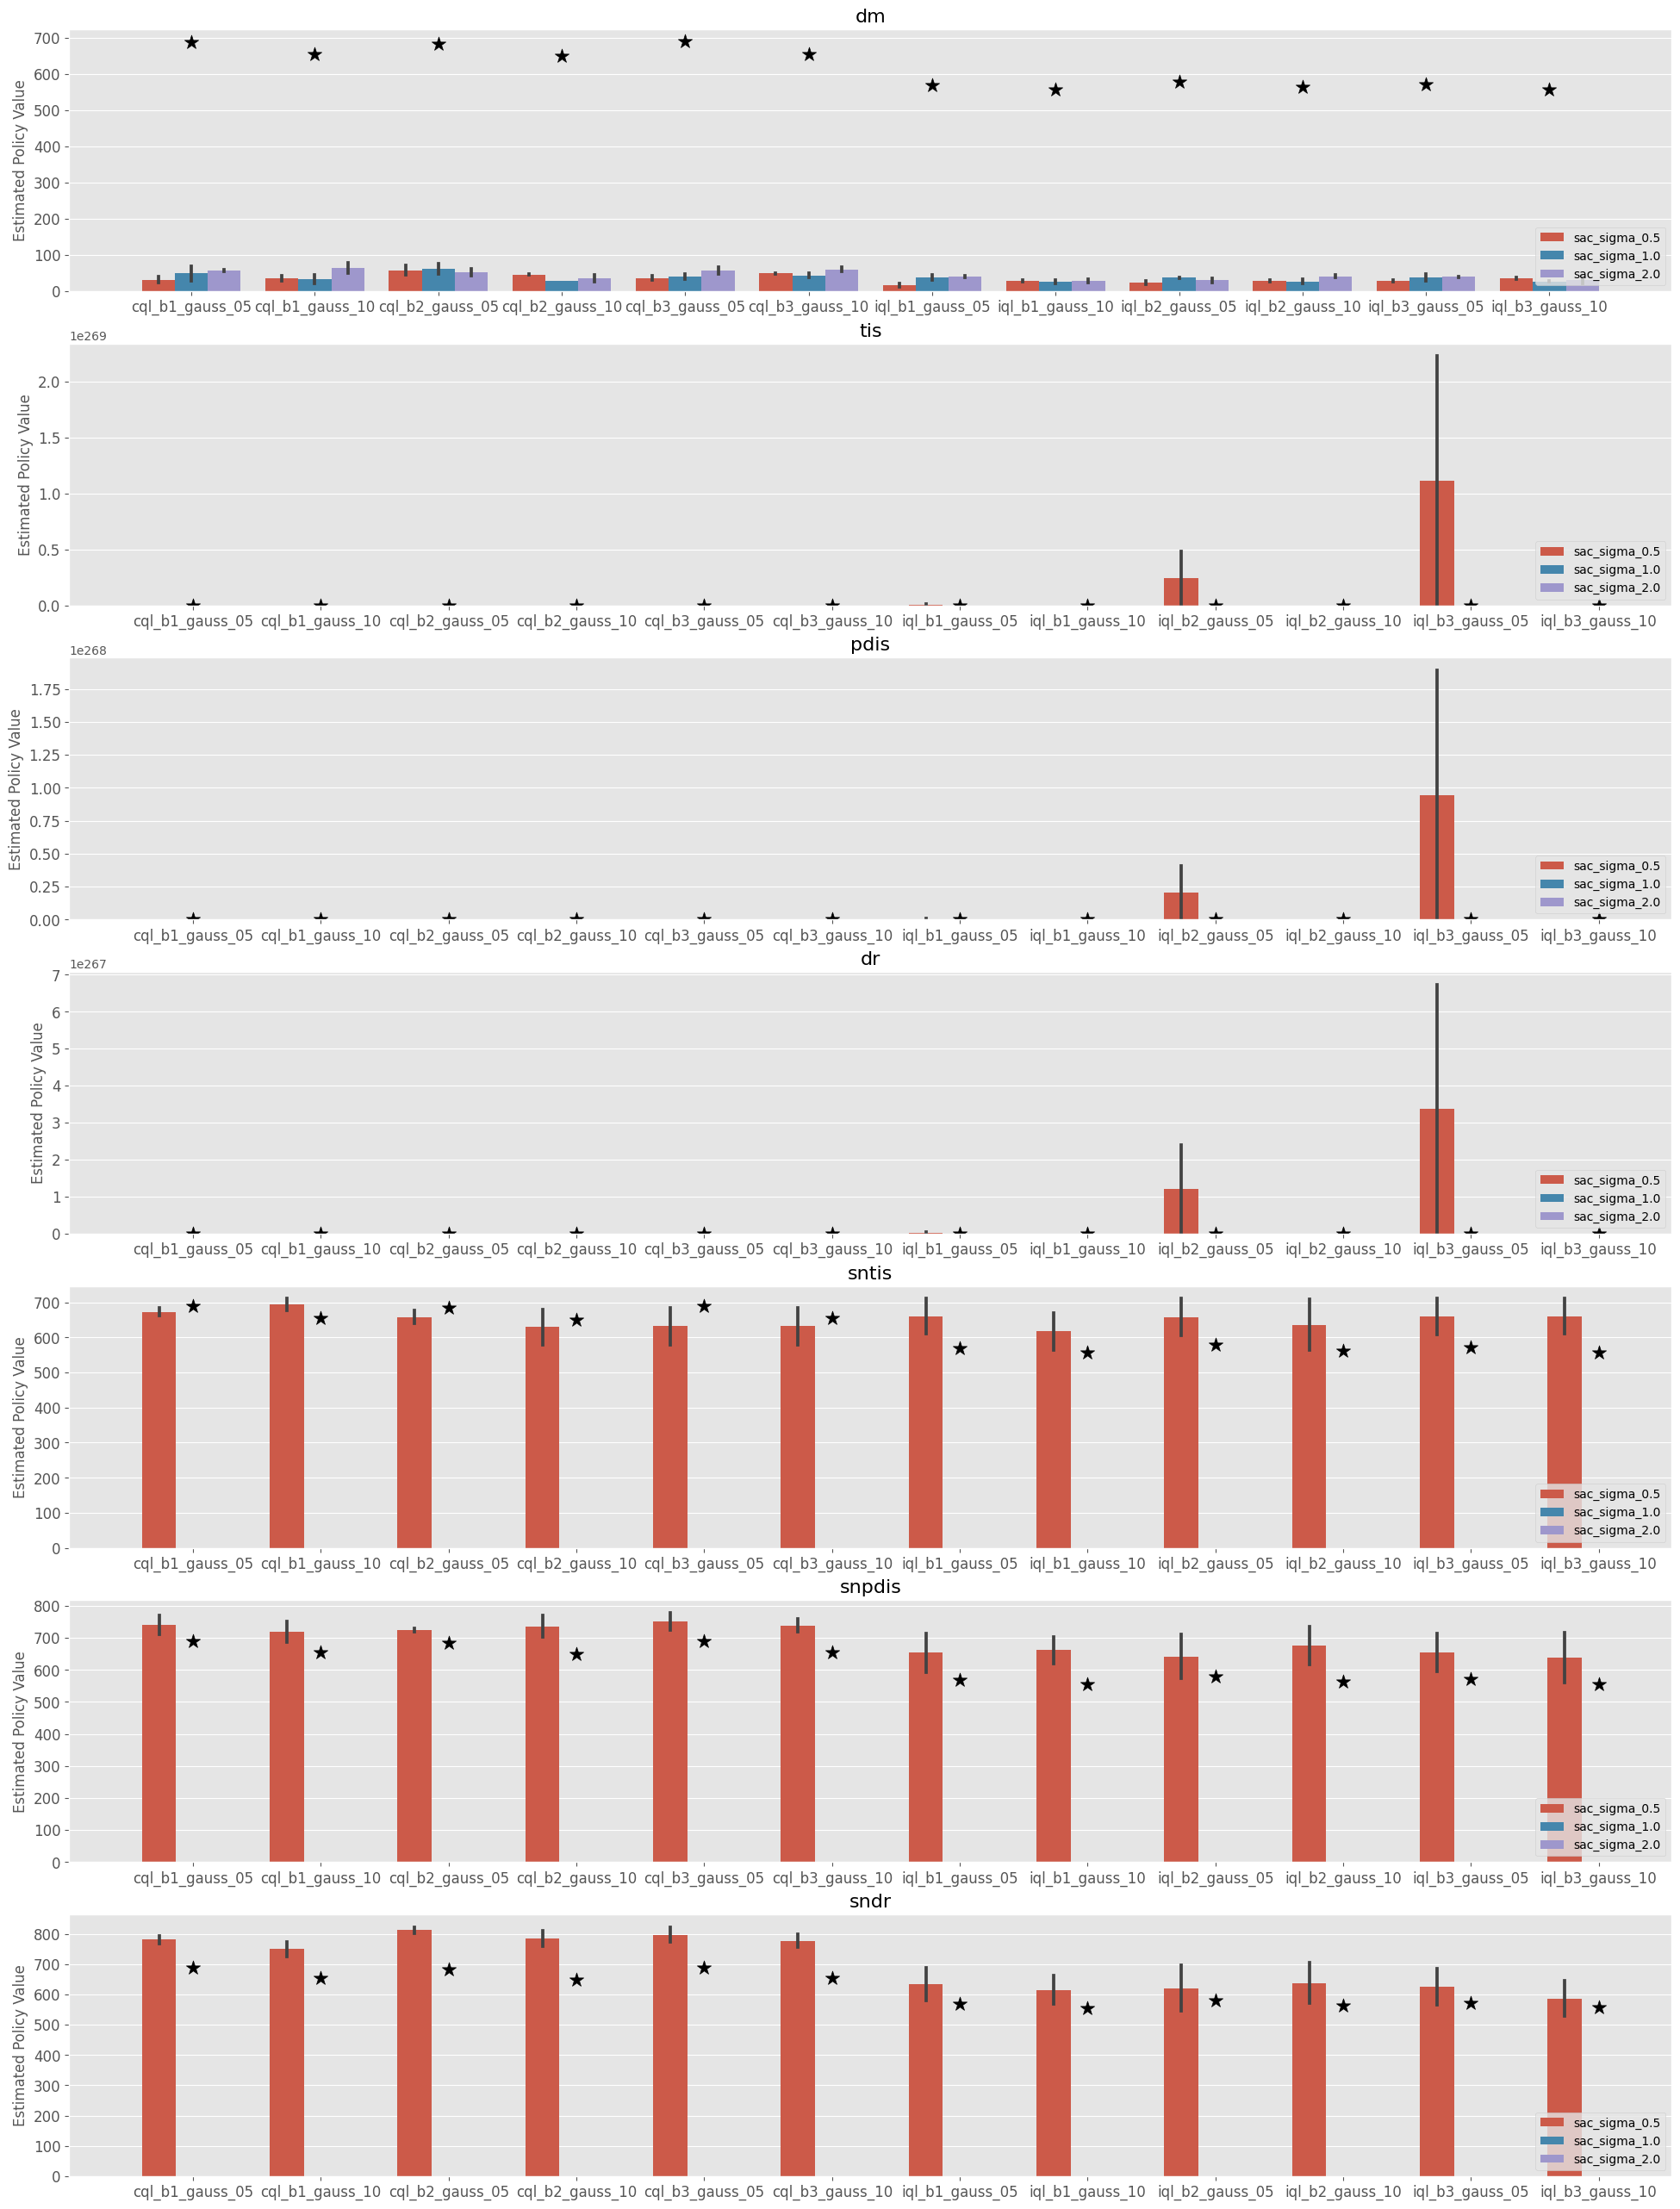

In [42]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

In [43]:
input_dict

MultipleInputDict(action_type='continuous', path=PosixPath('input_dict'), save_relative_path=False)

ValueError: array must not contain infs or NaNs

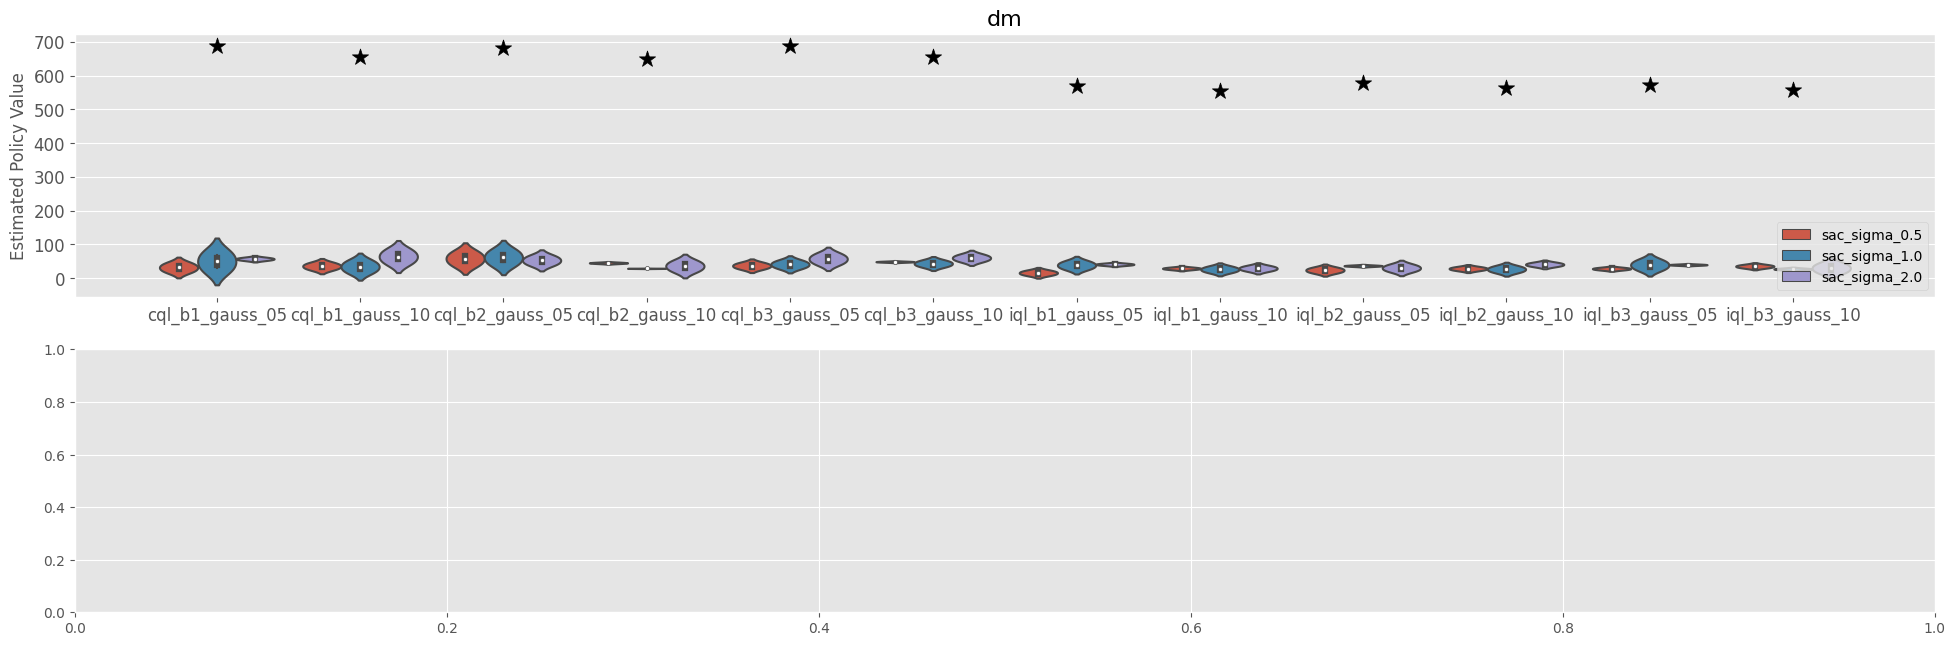

In [44]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

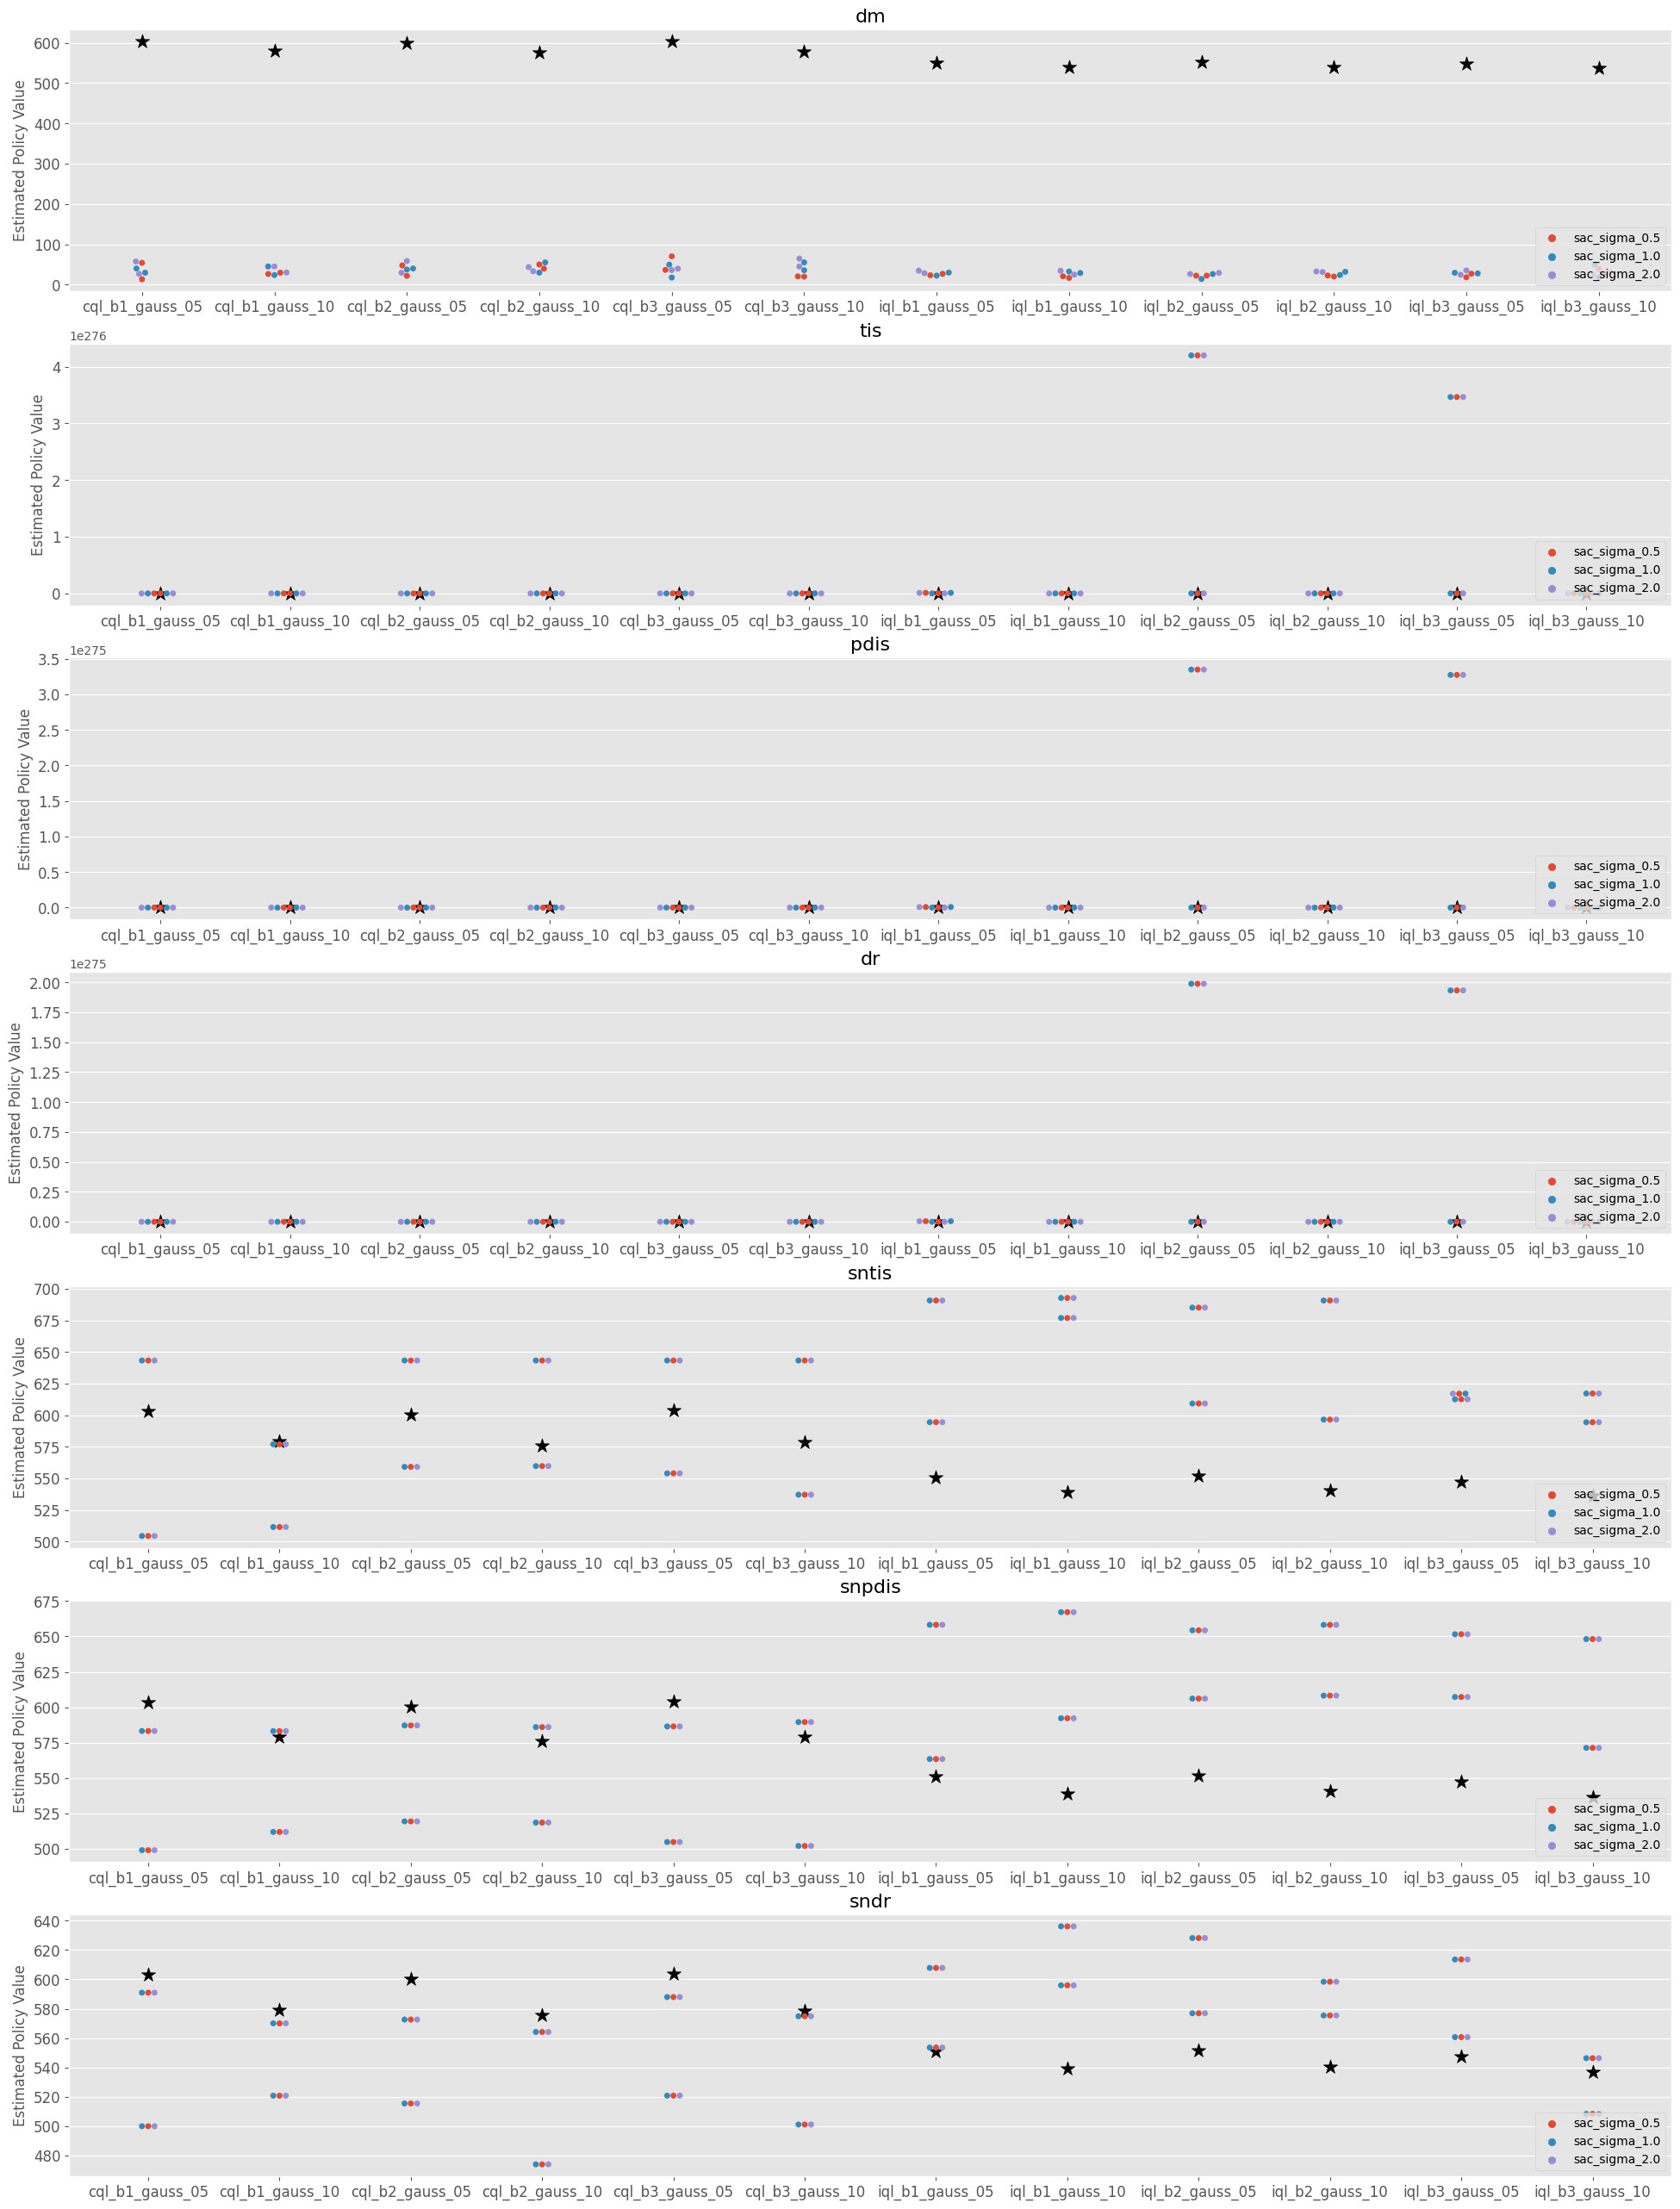

In [ ]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [ ]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [ ]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
    n_cols=4,
)

ValueError: operands could not be broadcast together with shapes (10000,) (100000,) 

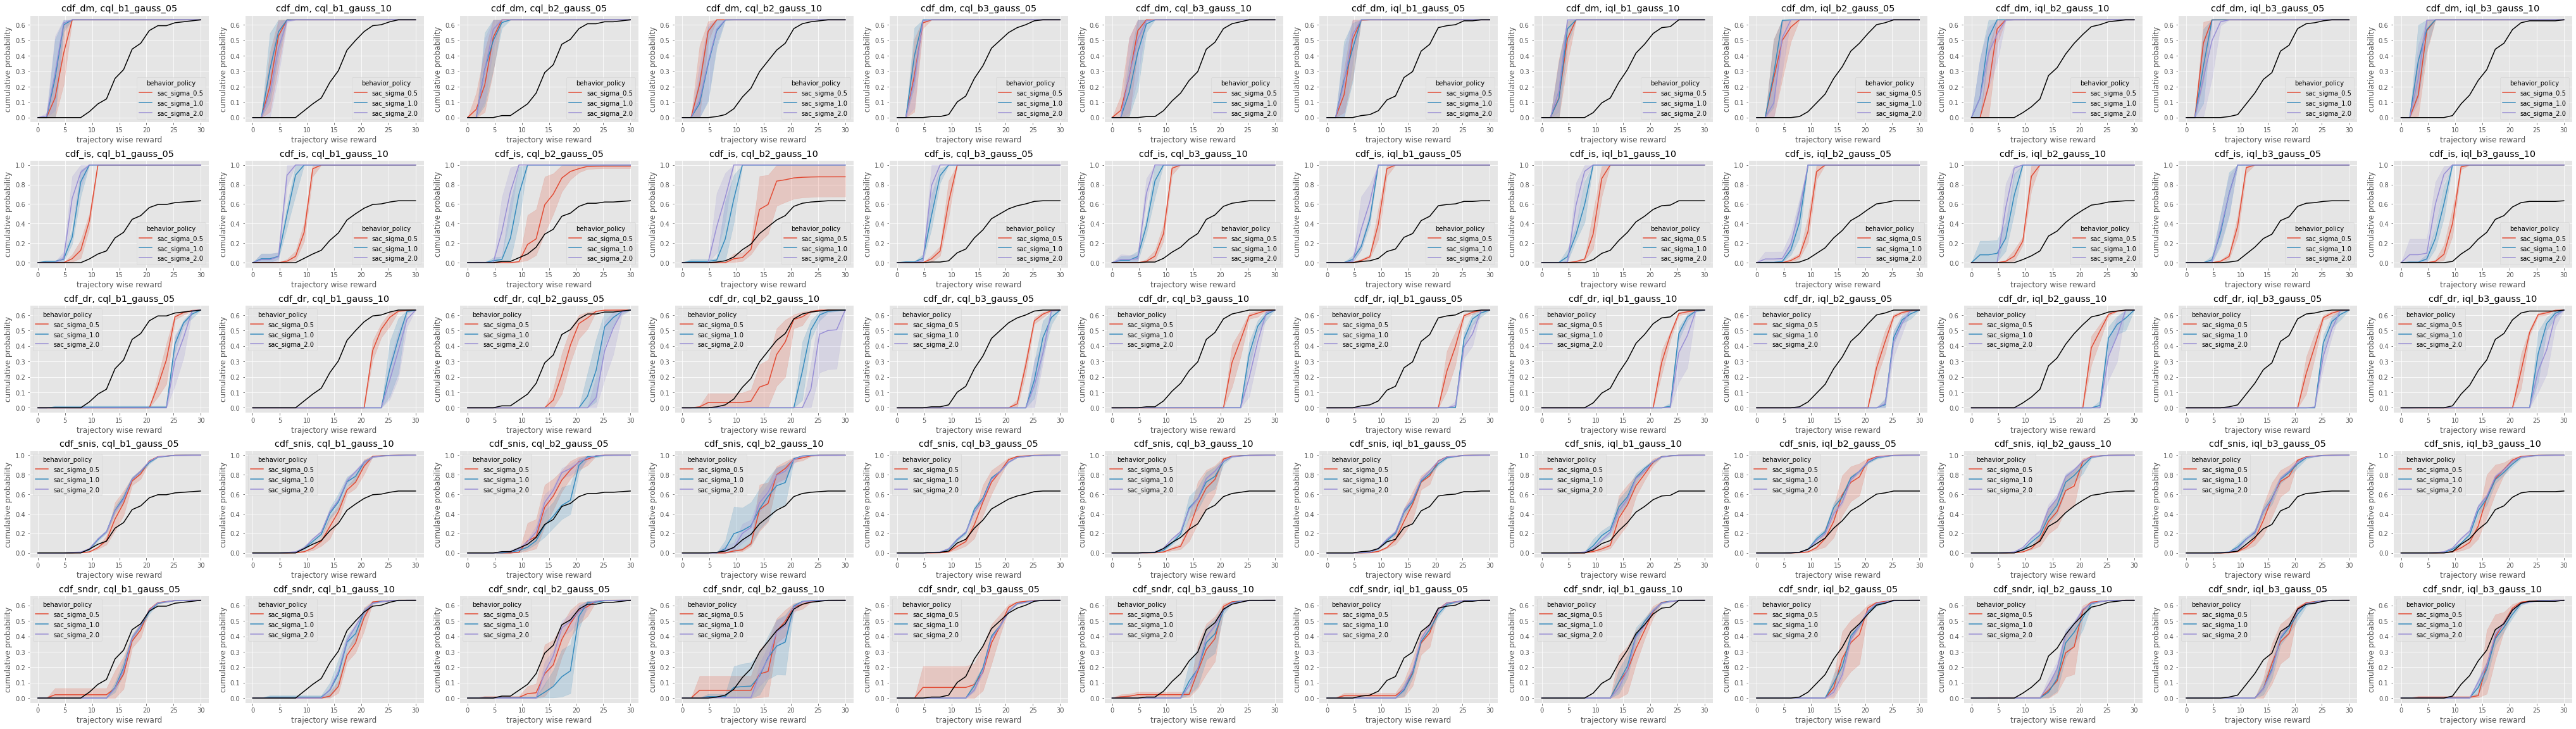

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

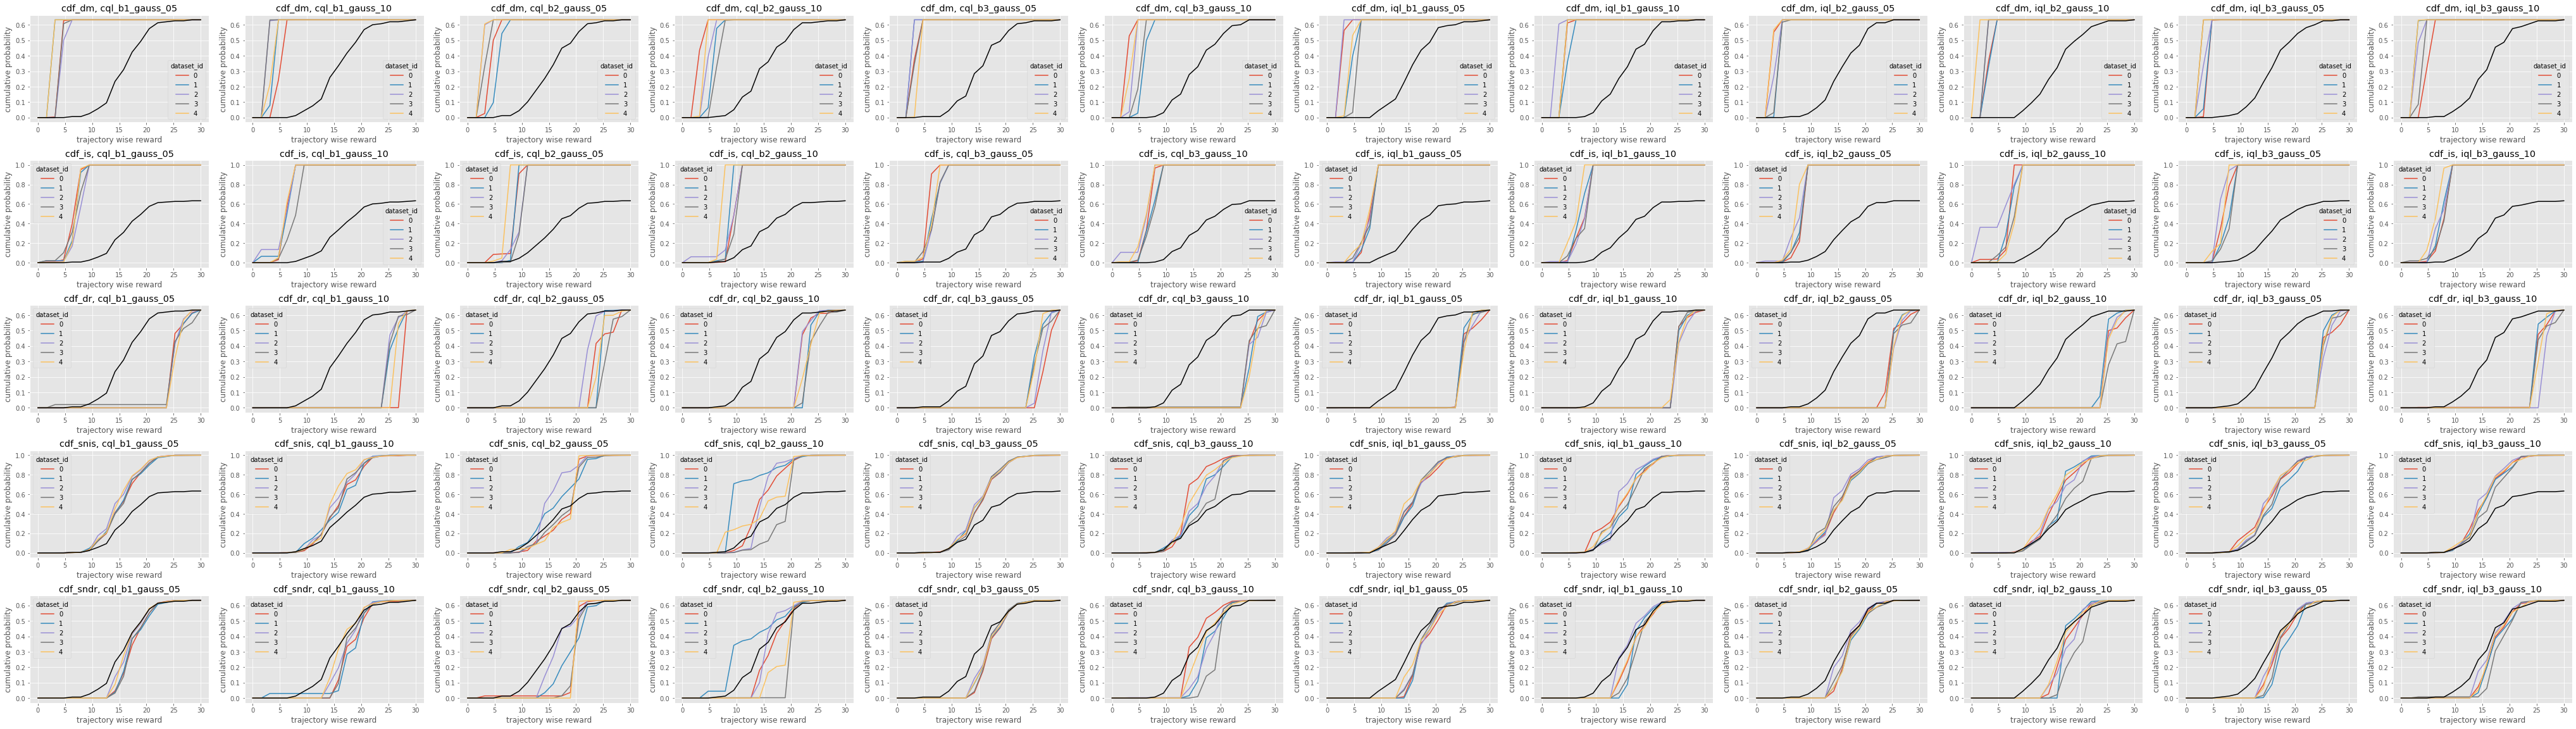

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

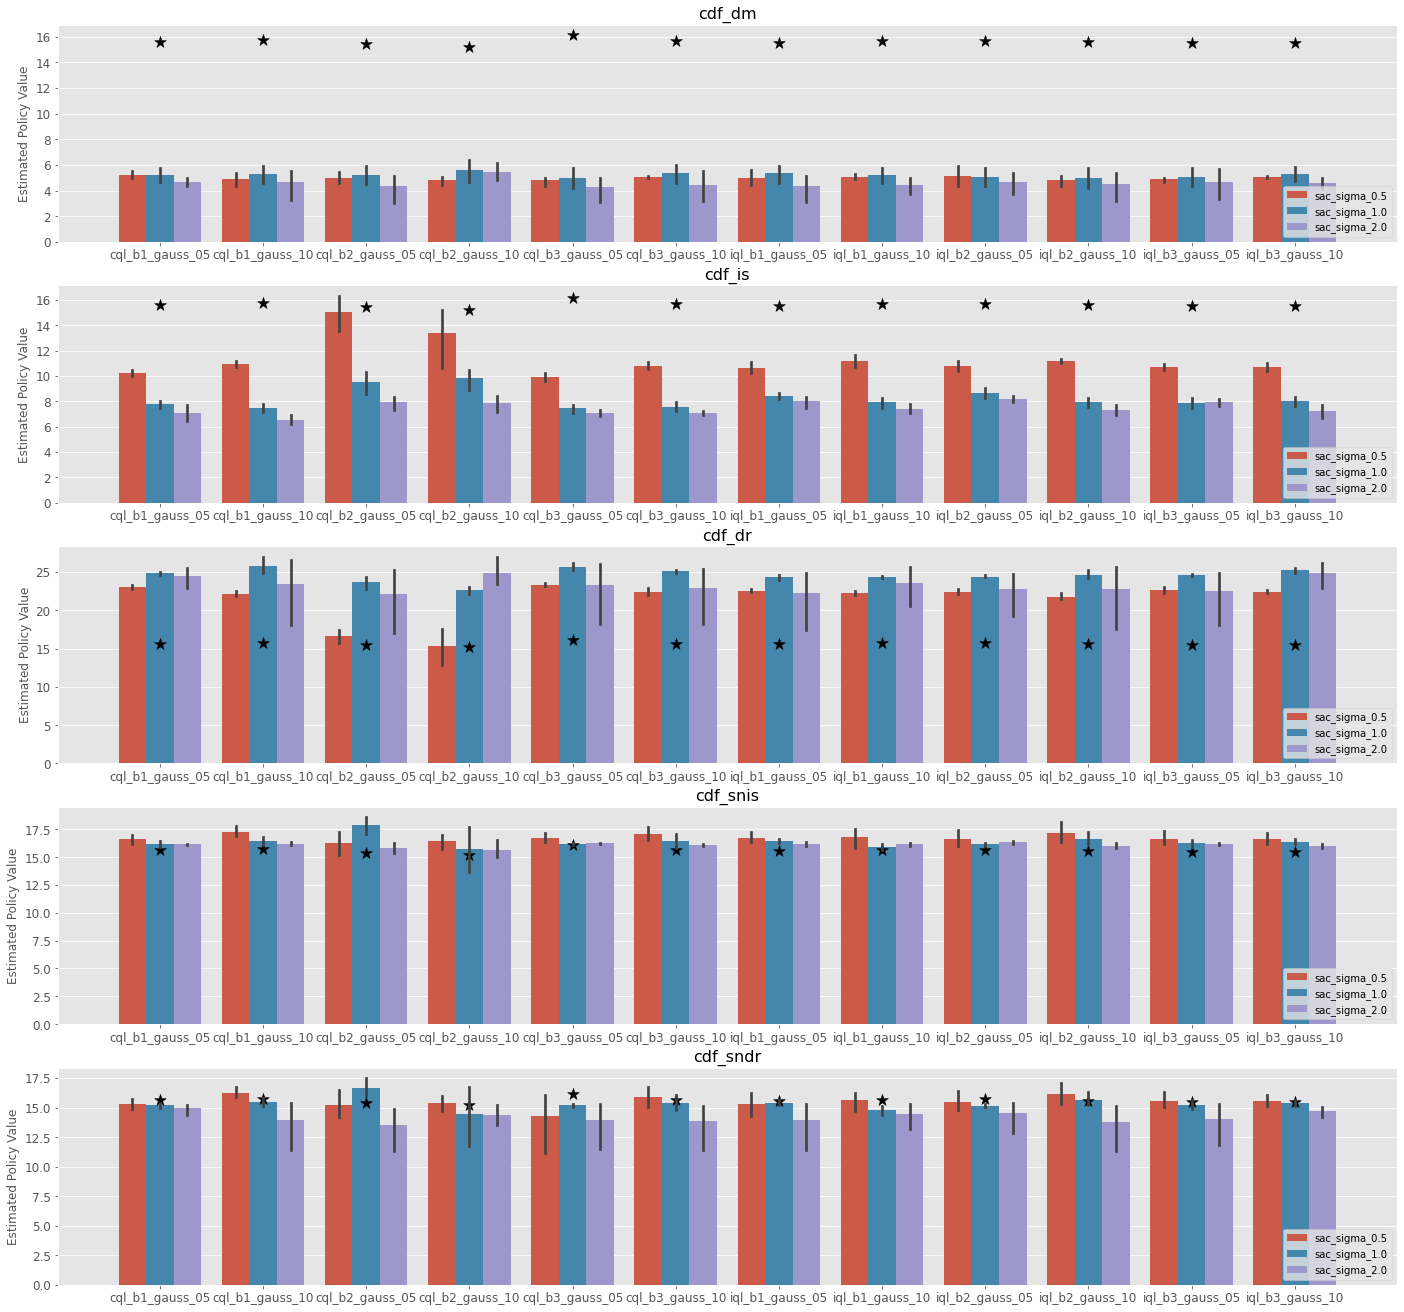

In [ ]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

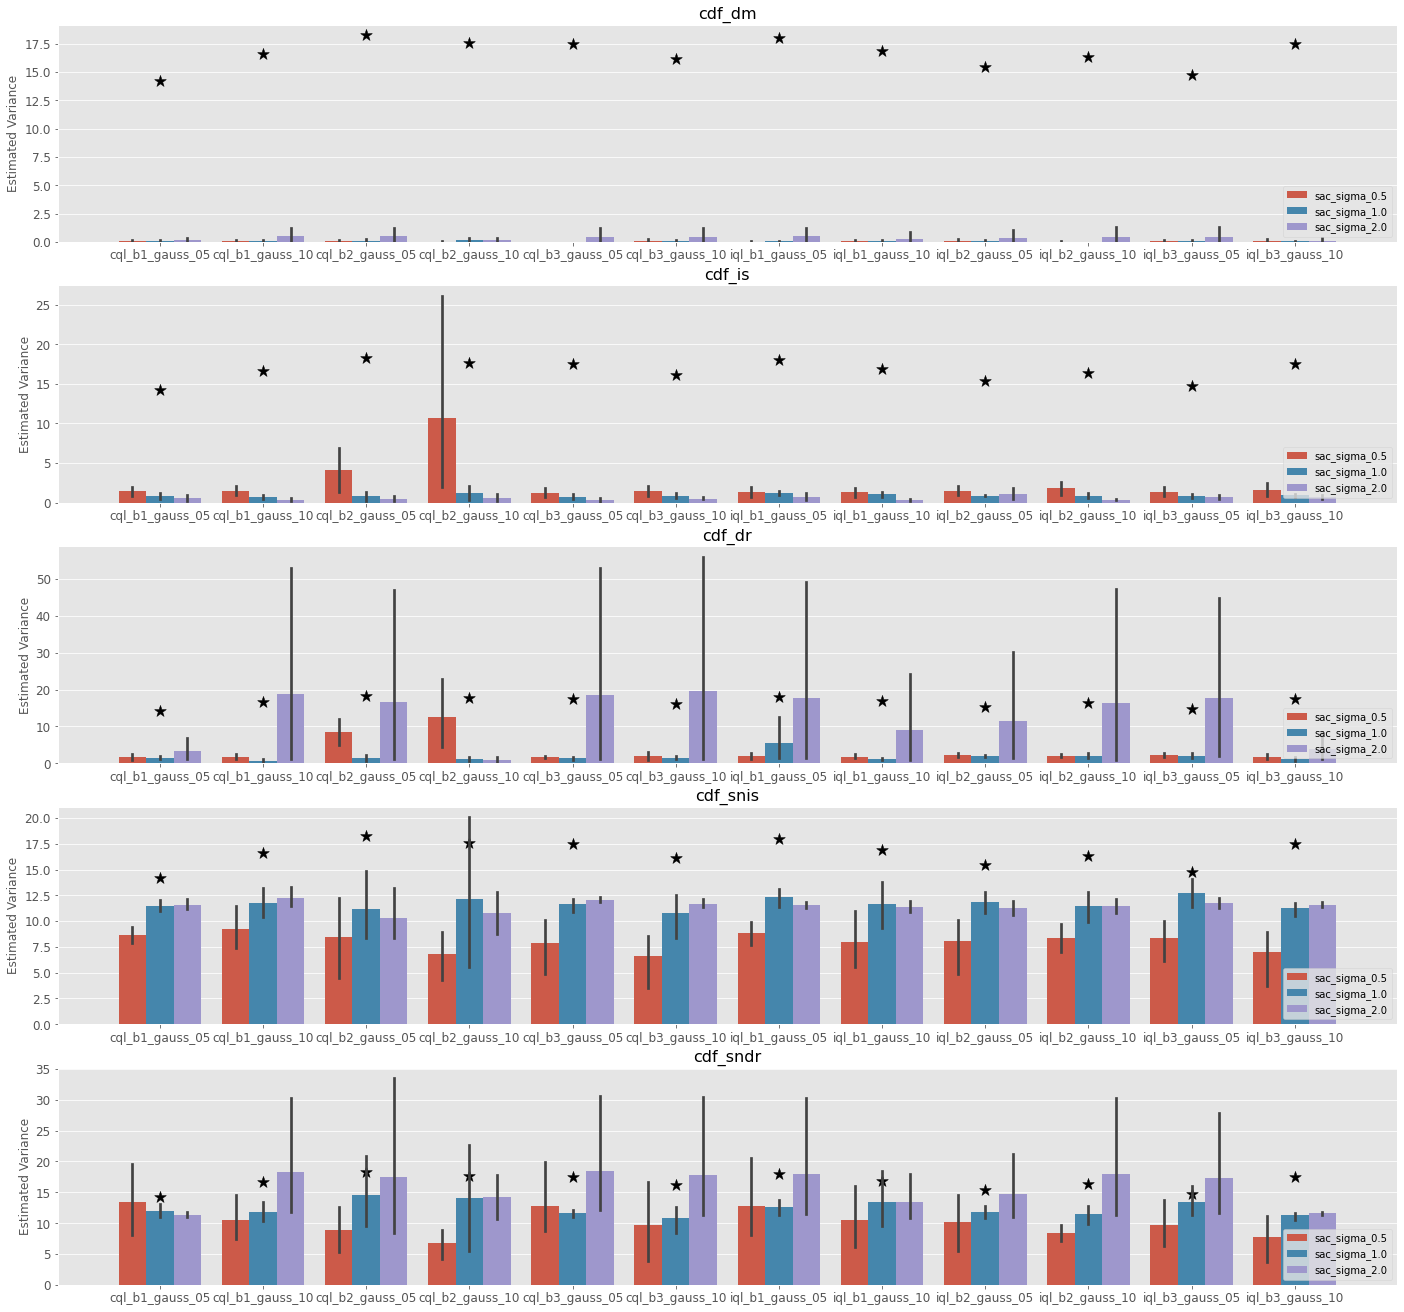

In [ ]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

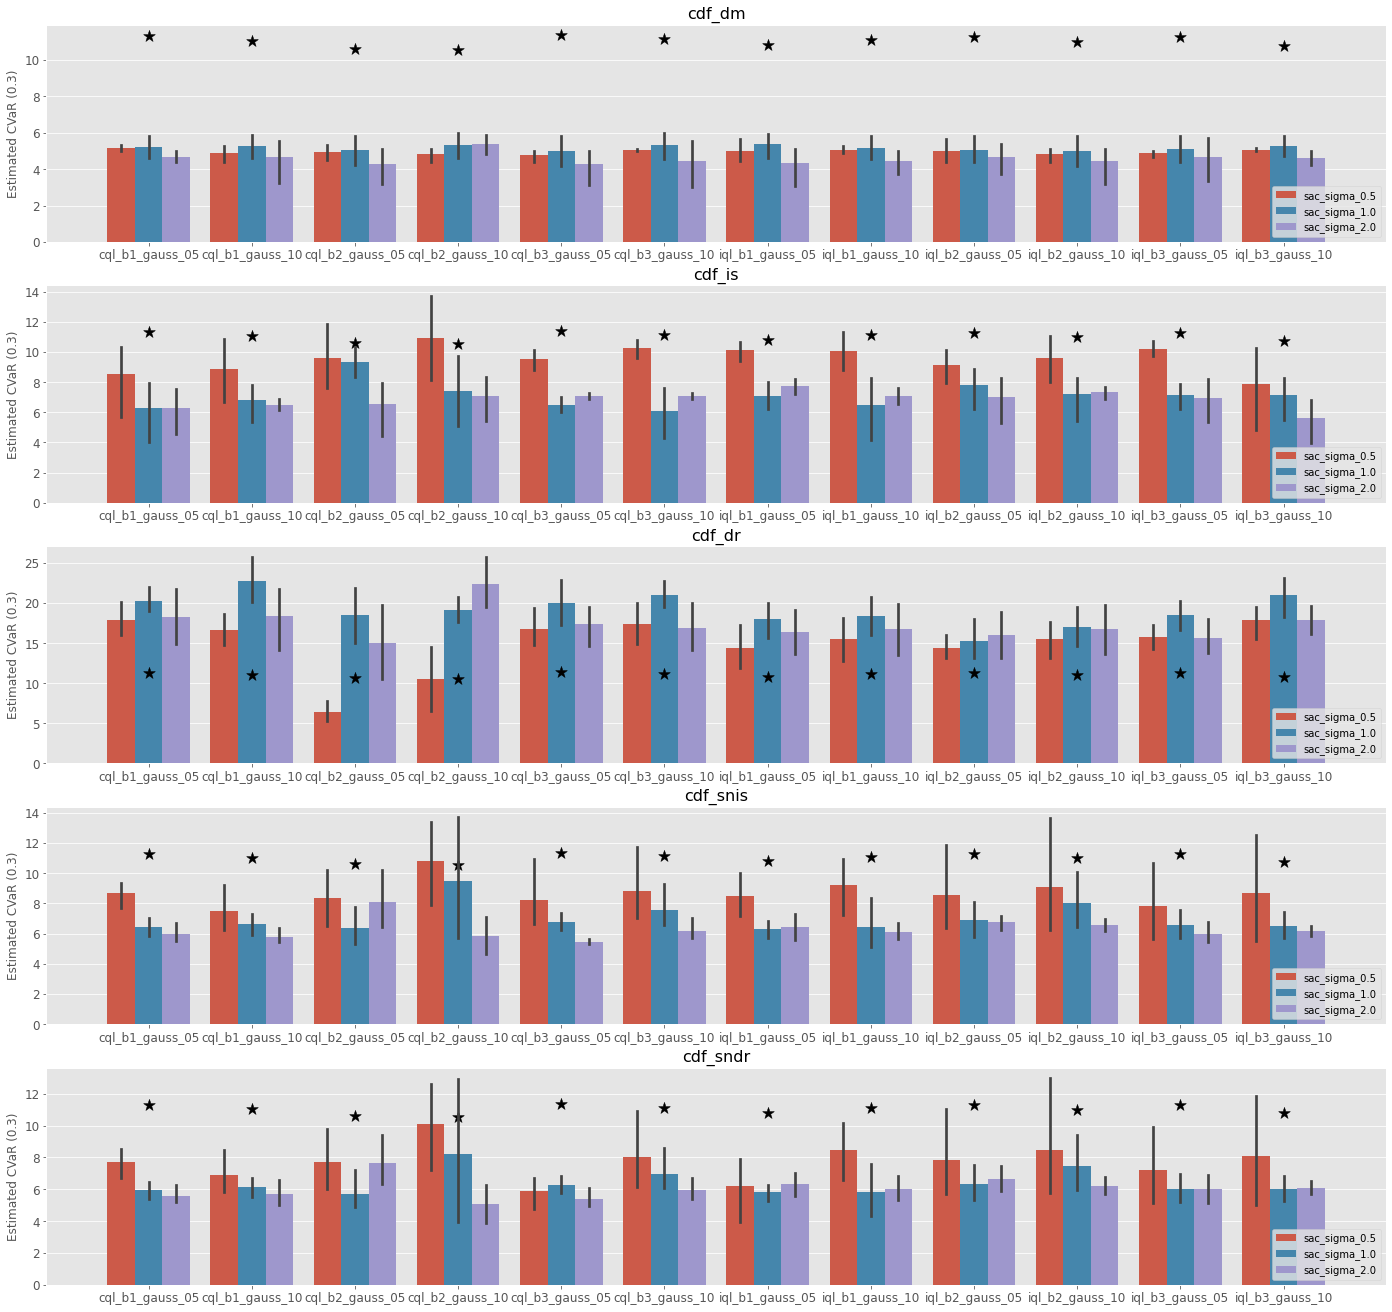

In [ ]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

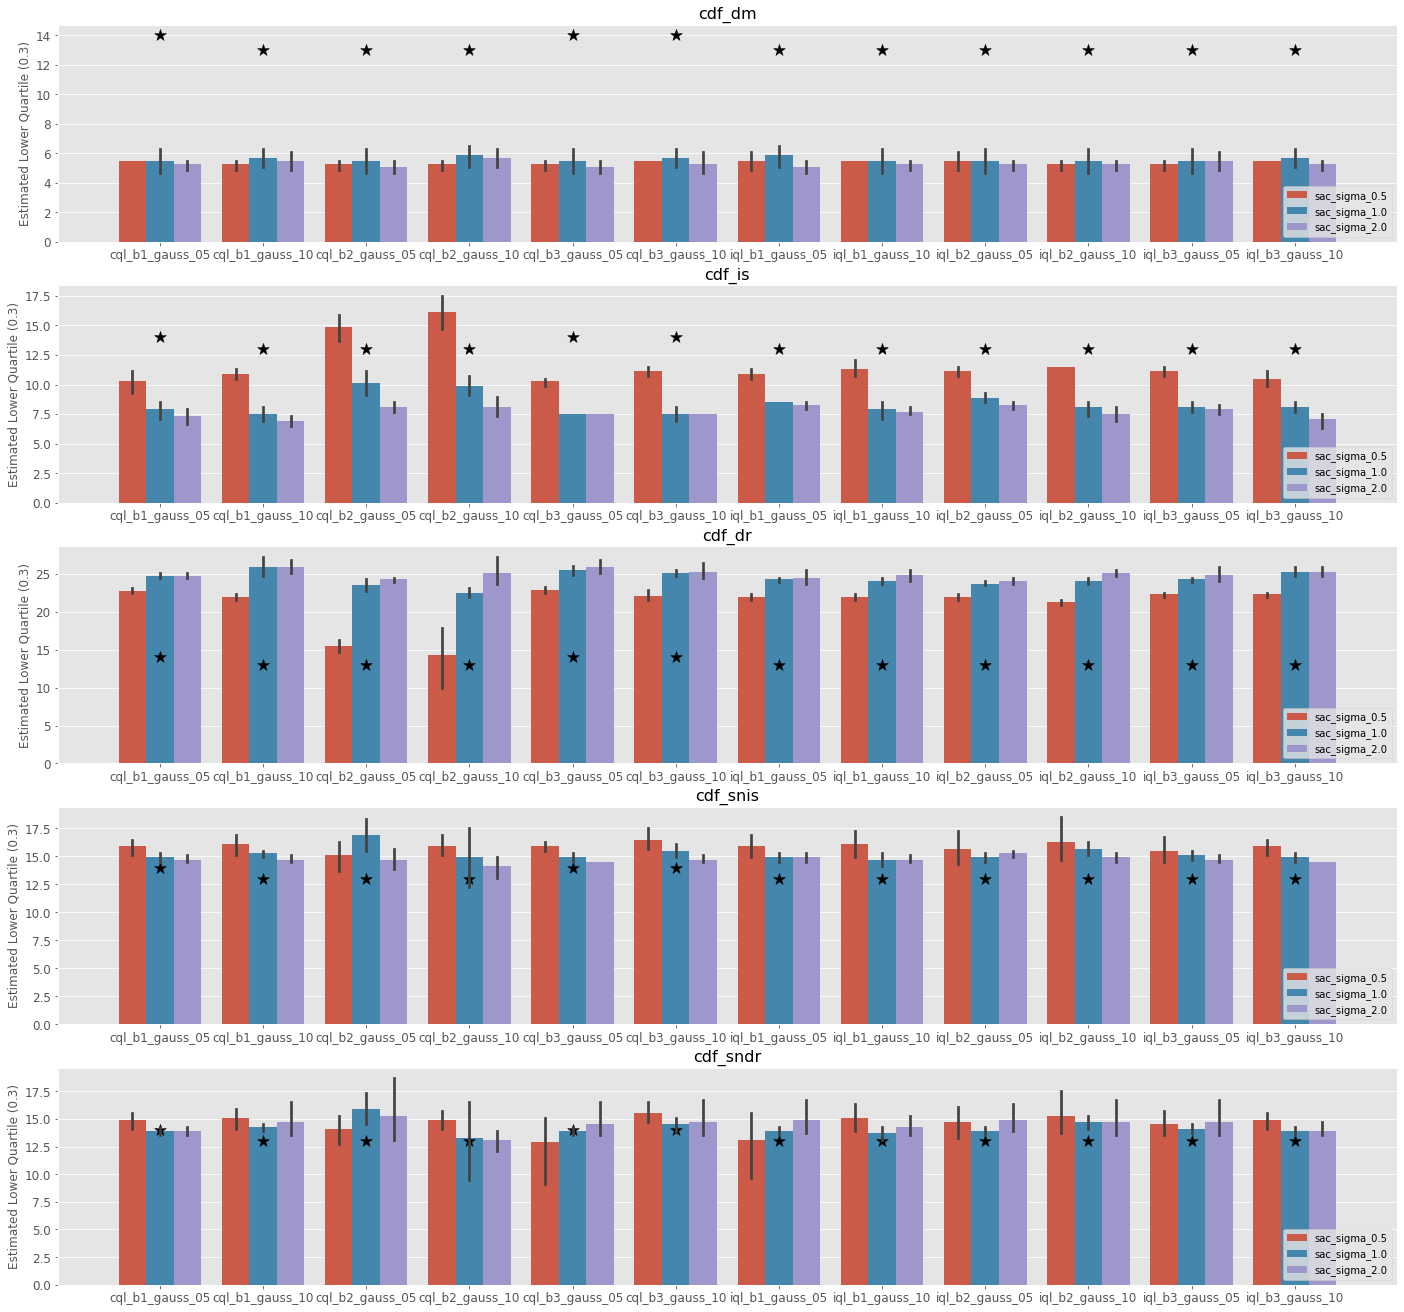

In [ ]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [ ]:
from ofrl.ope import OffPolicySelection

In [ ]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [ ]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[behavior_policies[0].name][0]

ranking  policy_value  relative_policy_value   variance  \
0   cql_b3_gauss_05         16.12               1.063682  17.440000   
1   cql_b1_gauss_10         15.72               1.037288  16.587475   
2   iql_b2_gauss_05         15.69               1.035309  15.407980   
3   iql_b1_gauss_10         15.66               1.033329  16.873131   
4   cql_b3_gauss_10         15.64               1.032009  16.151919   
5   cql_b1_gauss_05         15.62               1.030690  14.217778   
6   iql_b2_gauss_10         15.58               1.028050  16.306667   
7   iql_b1_gauss_05         15.54               1.025411  17.947879   
8   iql_b3_gauss_10         15.51               1.023431  17.444343   
9   iql_b3_gauss_05         15.50               1.022772  14.717172   
10  cql_b2_gauss_05         15.40               1.016173  18.242424   
11  cql_b2_gauss_10         15.22               1.004296  17.587475   

   ranking_by_lower_quartile  lower_quartile  \
0            cql_b1_gauss_05           10.00   
1            cql_b1_gauss_10            9.95   
2            cql_b2_gauss_05            9.95   
3            cql_b2_gauss_10            9.00   
4            cql_b3_gauss_05            9.00   
5            cql_b3_gauss_10            9.00   
6            iql_b1_gauss_05            9.00   
7            iql_b1_gauss_10            9.00   
8            iql_b2_gauss_05            8.00   
9            iql_b2_gauss_10            8.00   
10           iql_b3_gauss_05            8.00   
11           iql_b3_gauss_10            7.95   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                       cql_b3_gauss_10                        8.8  
1                       iql_b3_gauss_05                        8.6  
2                       iql_b2_gauss_05                        8.6  
3                       cql_b1_gauss_05                        8.6  
4                       iql_b1_gauss_10                        8.4  
5                       cql_b3_gauss_05                        8.4  
6                       cql_b1_gauss_10                        8.4  
7                       iql_b2_gauss_10                        7.8  
8                       cql_b2_gauss_10                        7.2  
9                       cql_b2_gauss_05                        7.2  
10                      iql_b1_gauss_05                        7.0  
11                      iql_b3_gauss_10                        6.4

In [ ]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [ ]:
ranking_df[behavior_policies[0].name][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0    iql_b1_gauss_05                5.571285                         0.367623   
 1    iql_b2_gauss_10                4.607152                         0.304004   
 2    cql_b2_gauss_10                4.359890                         0.287688   
 3    cql_b3_gauss_05                4.214110                         0.278069   
 4    cql_b3_gauss_10                4.199882                         0.277130   
 5    cql_b1_gauss_10                4.166754                         0.274944   
 6    iql_b1_gauss_10                3.971729                         0.262076   
 7    cql_b2_gauss_05                3.905723                         0.257720   
 8    iql_b3_gauss_10                3.656548                         0.241278   
 9    cql_b1_gauss_05                3.304909                         0.218075   
 10   iql_b2_gauss_05                2.531719                         0.167056   
 11   iql_

In [ ]:
metric_df[behavior_policies[0].name][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm        1.378196e+02          0.013986  0.965590      0.58   
1       tis        6.776106e+06          0.496503  0.100603      0.61   
2      pdis        3.124379e+04          0.657343  0.020185      0.48   
3        dr        1.836657e+05         -0.510490  0.089914      0.62   
4     sntis        7.391246e-01         -0.153846  0.633091      0.40   
5    snpdis        3.322909e+00          0.615385  0.033170      0.40   
6      sndr        4.617085e+00          0.594406  0.041521      0.40   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.5                 0.0  
4                0.0                 0.0  
5                0.0                 0.0  
6                0.0                 0.0

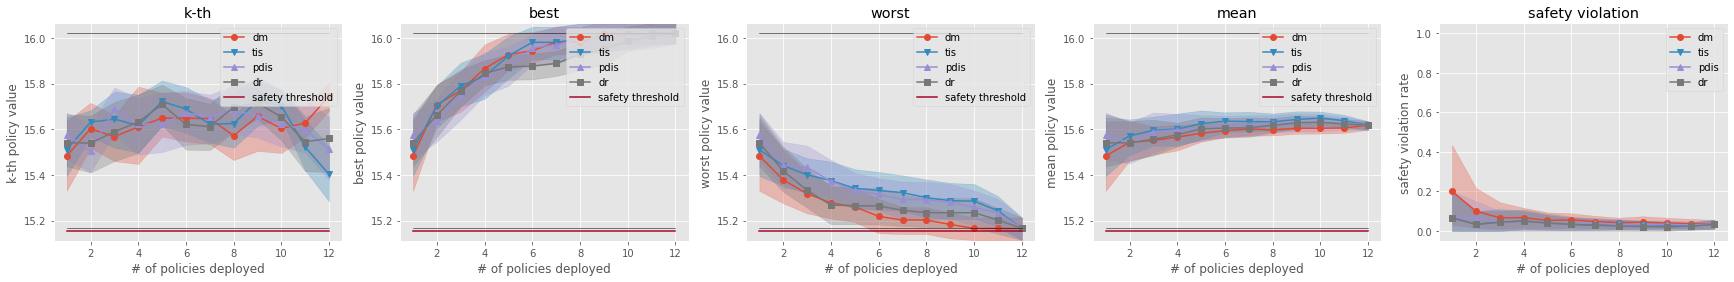

In [ ]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

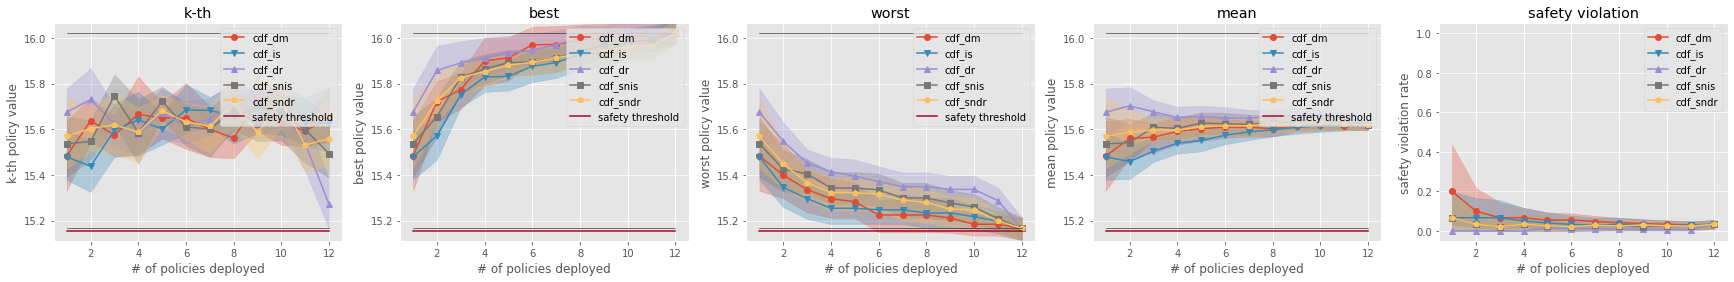

In [ ]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

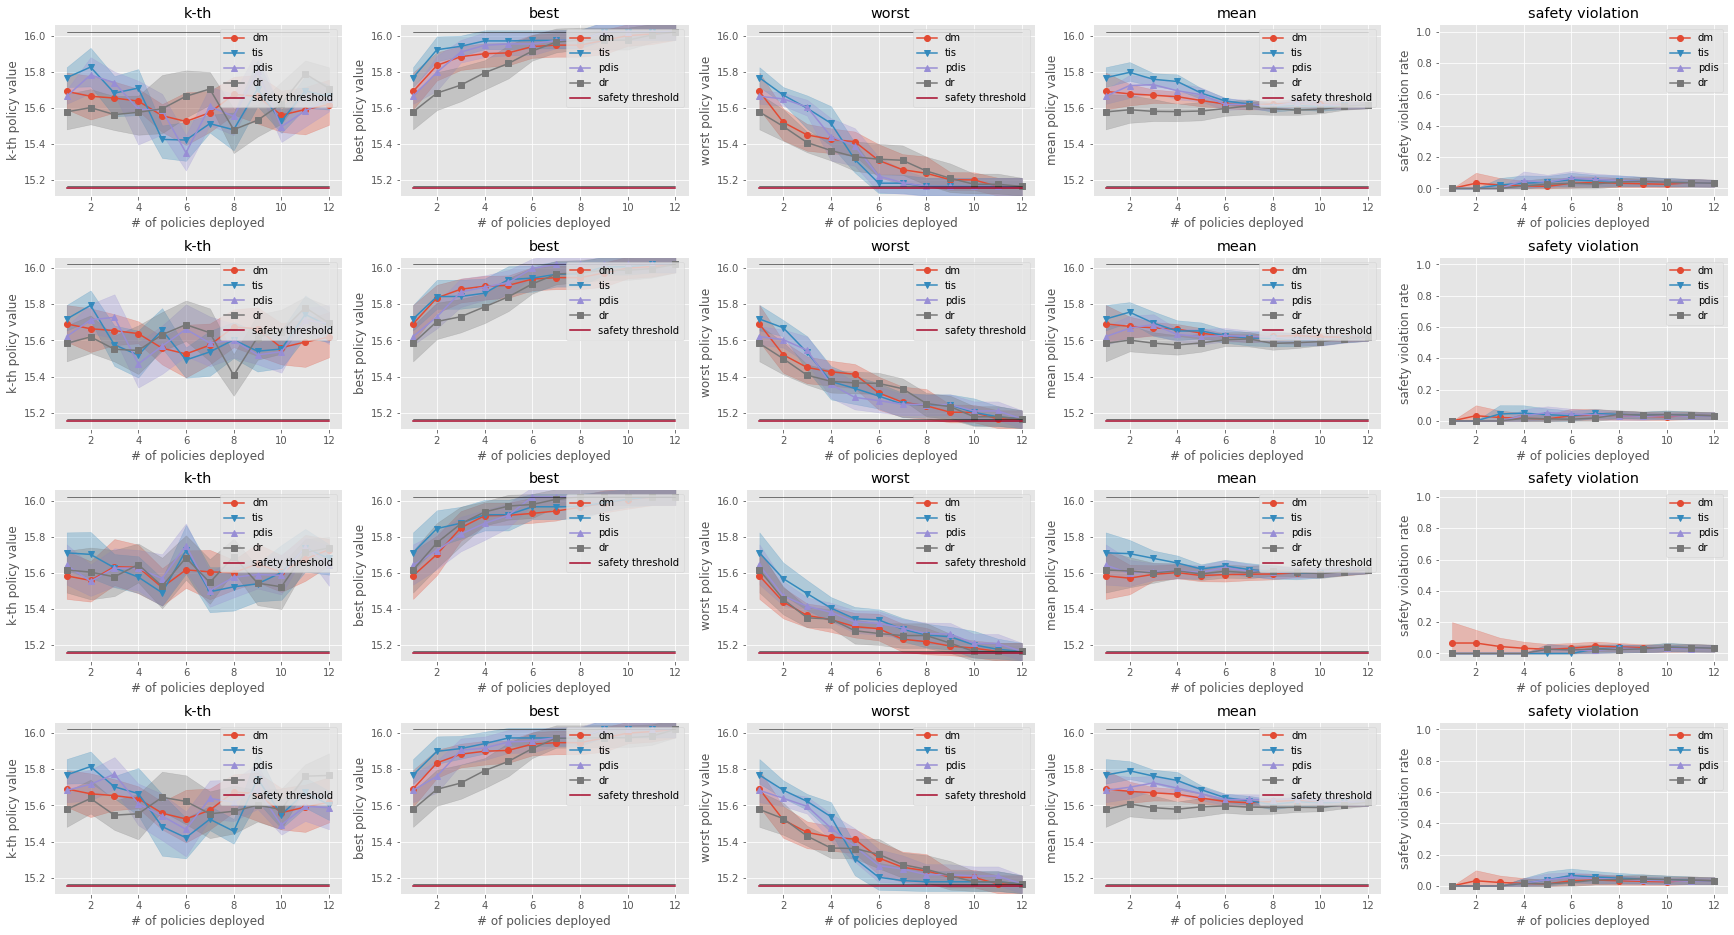

In [ ]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

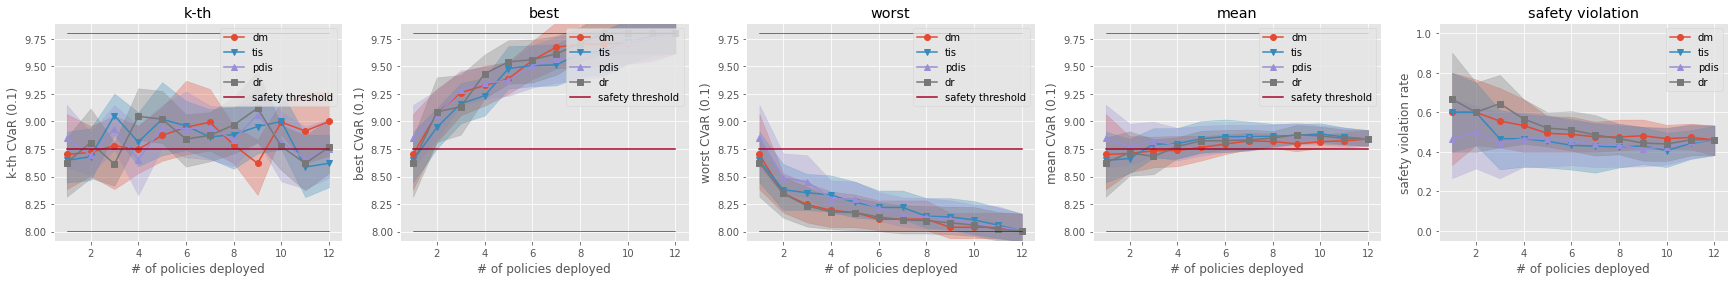

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

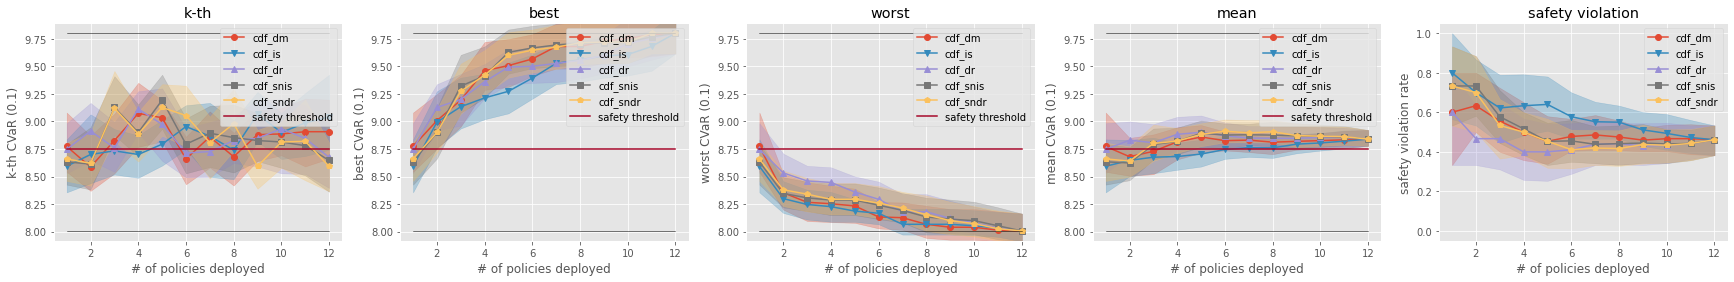

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

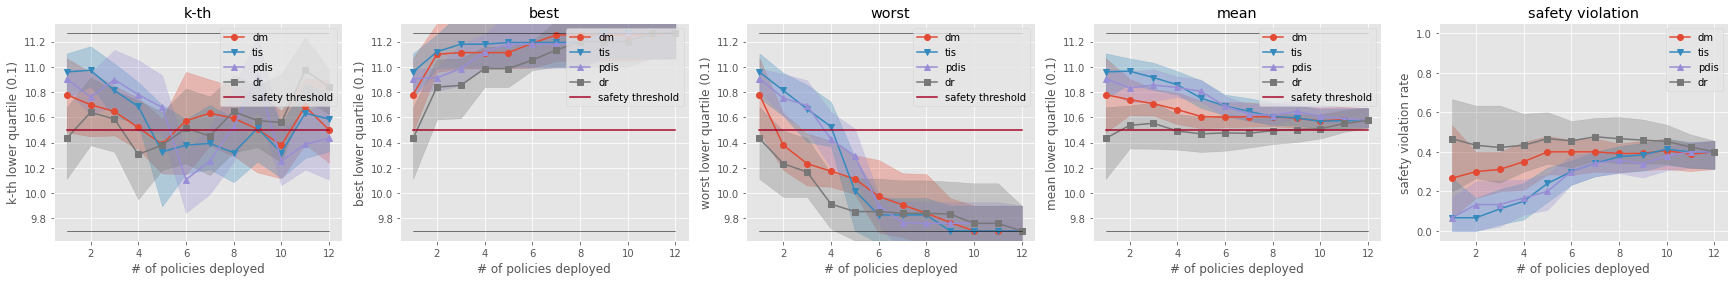

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

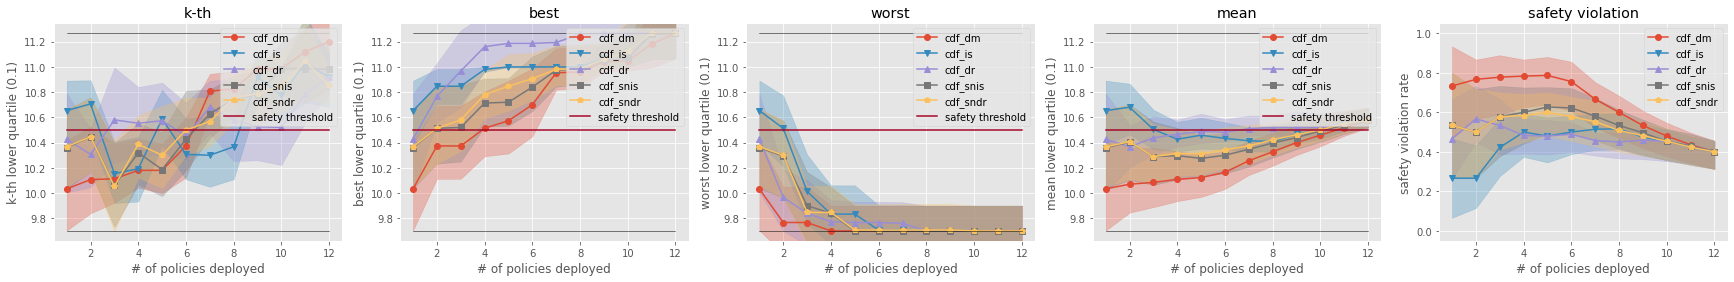

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

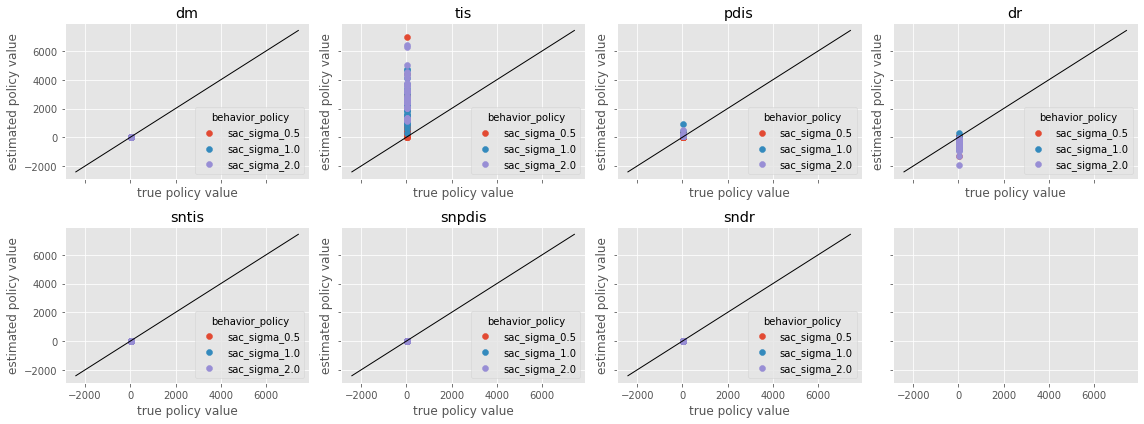

In [ ]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

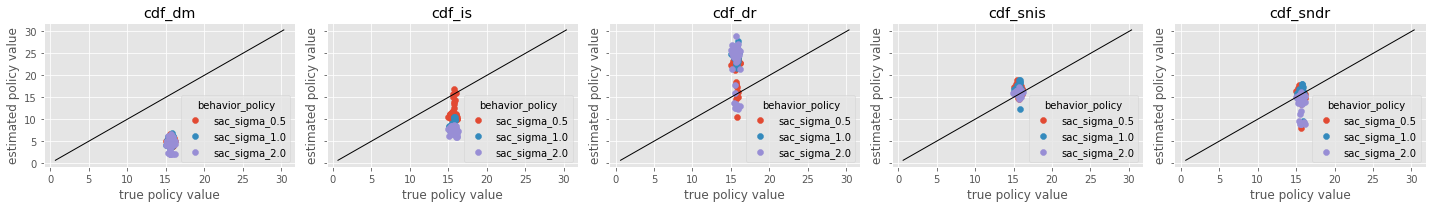

In [ ]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

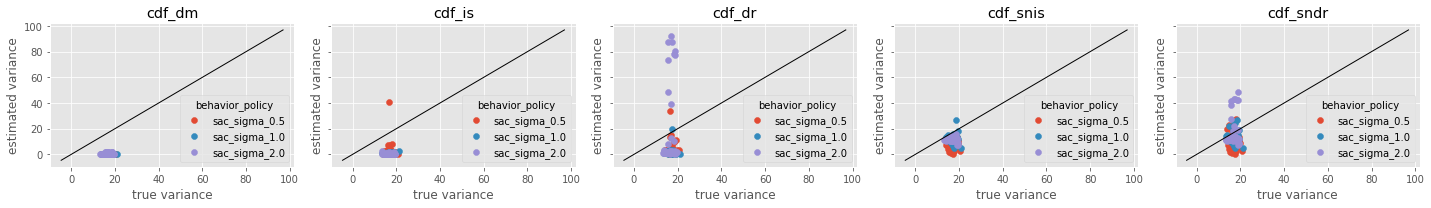

In [ ]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

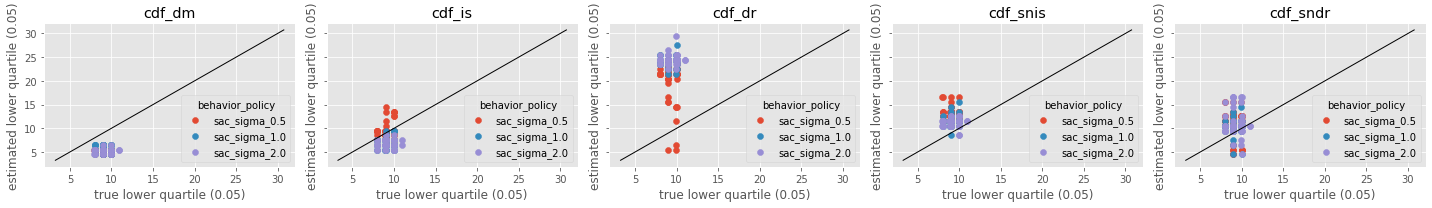

In [ ]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

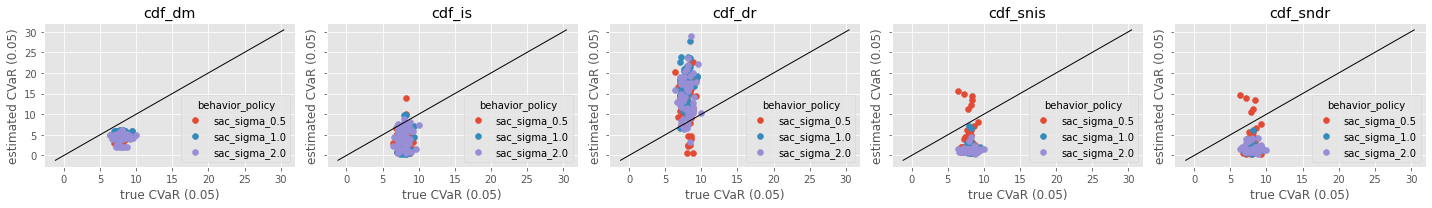

In [ ]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.